# Canadian Data job Market analysis

### Table of Contents
1. [**Import of Most Important Libraries**](#1-import-of-most-important-libraries)
    - [Load and merge all the data files.](#1-import-of-most-important-libraries)
2. [**Data Preliminary Cleaning**](#2-data-preliminary-cleaning)
3. [ **Exploratory Data Analysis**](#3-exploratory-data-analysis)
    - [3.1. WordCloud of Most Frequent Words](#31-wordcloud-of-most-frequent-words)
    - [3.2. Distribution of Job Postings Across Canadian Cities](#32-distribution-of-job-postings-across-canadian-cities)
    - [3.3. K-means Clusters for Distinct Jobs](#33-k-means-clusters-for-distinct-jobs)
    - [3.4. Most In-Demand Jobs](#34-most-in-demand-jobs)
    - [3.5. Job Types Distribution](#35-job-types-distribution)
    - [3.6. Top In-Demand Skills](#36-top-in-demand-skills)
    - [3.7. Years of Experience](#37-years-of-experience)
    - [3.8. Education Requirements](#38-education-requirements)
    - [3.9. Seniority Levels](#39-seniority-levels)
4. [**Salary Exploration (Descriptive)**](#4-salary-exploration-descriptive)
    - [4.1. Salary Cleaning](#41-salary-cleaning)
        - [4.1.1. Using Regular Expressions](#411-using-regular-expressions)
        - [4.1.2. Using NER (Named Entity Recognition) Transformer Models (tested with 100 rows)](#412-testing-nlp-to-extract-salary-information)
    - [4.2. Salary Distributions and Plots](#42-salary-distributions-and-plots)
5. [**Salary Models and Predictions**](#5-salary-models-and-predictions)
    - [5.1. Cleaning and Linear Regression](#51-cleaning-and-linear-regression)
    - [5.2. Random Forest](#52-random-forest)
    - [5.3. Fine-Tuning a Deep Learning Transformer Model](#53-fine-tuning-a-deep-learning-transformer-model)



# 1. **Import of Most Important Libraries**

In [1]:
import pandas as pd
from collections import Counter
import nltk
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt


nltk.download('punkt')
nltk.download('stopwords')
##import regular expression
import re 
import matplotlib.pyplot as plt

# Load the CSV files
df1 = pd.read_csv('./Scraper/jobs_2024-03-16_16-06.csv')
df2 = pd.read_csv('./Scraper/jobs_2024-03-17_23-33.csv')
df3 = pd.read_csv('./Scraper/jobs_2024-03-18_12-47.csv')
df4 = pd.read_csv('./Scraper/jobs_2024-03-25_00-03.csv')
df5 = pd.read_csv('./Scraper/jobs_2024-03-23_18-20.csv')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


concatenate multiple dataframes from multiple scrape dates


# 2. **Data Preliminary Cleaning**

In [2]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)
to_merge = [df1,df2,df3,df4,df5]
df_merge = pd.concat(to_merge)

print("Merged DF shape",df_merge.shape)

(2479, 10)
(2467, 10)
(2064, 10)
(2494, 10)
(2468, 10)
Merged DF shape (11972, 10)


### Eliminate the duplicated jobs based on the  jobID

In [3]:

df_merge.drop_duplicates(subset='jobID', keep='first', inplace=True)
print(df_merge.shape)
df = df_merge
print("current DF shape : ",df.shape)
        

(2598, 10)
current DF shape :  (2598, 10)


### Eliminating duplicated jobs based on Job title, description and company

In [4]:
df.drop_duplicates(subset=['company', 'title', 'description'], inplace=True)
print("New length: ",df.shape[0] )

New length:  2422


Remove Unnamed Column

In [5]:
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,title,company,description,location,jobID,jobType,salary,platform,posting_date
0,Data Scientist,AdventInfotech,Data Scientist:\n\nWe are seeking a highly mot...,"Vancouver, BC",M5XBjZtTkQ_D8mxYAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-15
1,Senior Data Scientist - Insights,Coursera,Coursera was launched in 2012 by two Stanford ...,Canada,VT_hfGMEKBPSIjP0AAAAAA%3D%3D,Full-time,NaN,Careers At Coursera,2024-03-14
2,Data Scientist,Why Hiring,"At Why Hiring, we believe in the power of conn...",Canada,mTH8GfFTq4sMk_mCAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-14
3,Data Scientist - Canada,Coinbase,"At Coinbase, our mission is to increase econom...","Toronto, ON",8CWTyYjpHwEtZznAAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-16
4,Lead Data Scientist,Equifax,Do you have a passion for being at the forefro...,"Toronto, ON",38aVIkOwDVpGyeUkAAAAAA%3D%3D,Full-time,NaN,Equifax Careers,NaN


Eliminate Elements with the description empty

In [6]:

print(df.shape)
df['description'].replace('', np.nan, inplace=True)
df.dropna(subset='description', inplace=True)
df.shape


(2422, 9)


(2420, 9)

### Get the province and the city , separately

In [7]:
print(f"Different locations: {len(df.location.unique())} ")

# temporary DataFrame from the split operation
temp_df = df['location'].str.split(', ', n=1, expand=True)

# If there is no comma, add the value to the 'Province' column
temp_df[1] = temp_df[1].fillna(temp_df[0])


# assigning the columns back to the original DataFrame
df[['City', 'Province']] = temp_df

df.head()


Different locations: 123 


,title,company,description,location,jobID,jobType,salary,platform,posting_date,City,Province
0,Data Scientist,AdventInfotech,Data Scientist:\n\nWe are seeking a highly mot...,"Vancouver, BC",M5XBjZtTkQ_D8mxYAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-15,Vancouver,BC
1,Senior Data Scientist - Insights,Coursera,Coursera was launched in 2012 by two Stanford ...,Canada,VT_hfGMEKBPSIjP0AAAAAA%3D%3D,Full-time,NaN,Careers At Coursera,2024-03-14,Canada,Canada
2,Data Scientist,Why Hiring,"At Why Hiring, we believe in the power of conn...",Canada,mTH8GfFTq4sMk_mCAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-14,Canada,Canada
3,Data Scientist - Canada,Coinbase,"At Coinbase, our mission is to increase econom...","Toronto, ON",8CWTyYjpHwEtZznAAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-16,Toronto,ON
4,Lead Data Scientist,Equifax,Do you have a passion for being at the forefro...,"Toronto, ON",38aVIkOwDVpGyeUkAAAAAA%3D%3D,Full-time,NaN,Equifax Careers,NaN,Toronto,ON


# 3. **Exploratory Data Analysis** <a id='Exploratory_Data_ Analysis'></a>

## 3.1. WordCloud of Most Frequent Words

### Let's Create a wordcloud to visualize the more important terms in our data

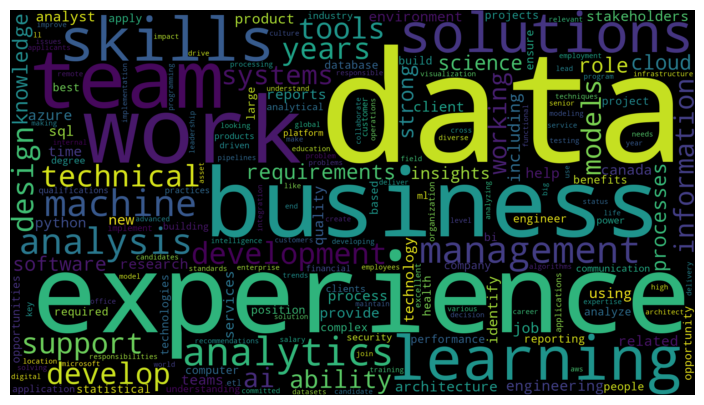

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Create TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['description'])


# Get the feature names from the vectorizer
features = vectorizer.get_feature_names_out()

# Sum up the TF-IDF of each feature across all documents in the dataset
importance = X.sum(axis=0).A1

# Create a dictionary mapping each feature to its importance
importance_dict = dict(zip(features, importance))

# Create a WordCloud object
wordcloud = WordCloud(width=1920, height=1080, background_color='black')

# Generate the word cloud
wordcloud.generate_from_frequencies(importance_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


##  3.2. Distribution of Job Postings Across Canadian Cities


## Get the Data for the top cities with the most Job Listings.

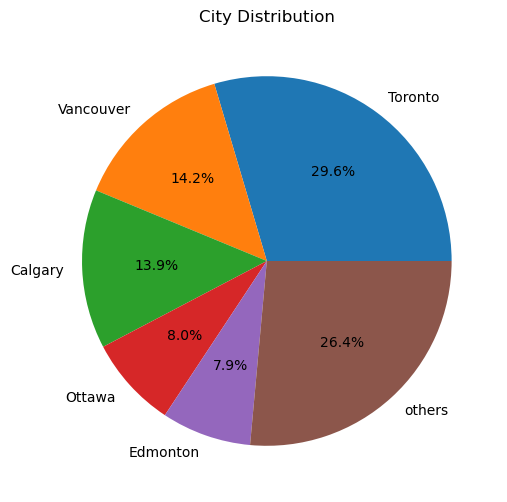

In [9]:

# Get unique cities that are not 'Canada'
unique_cities = df[df['City'] != 'Canada']['City'].unique()

# Count the occurrences of each city
counter = Counter(df['City'])

# Get the 5 most common cities
top_cities = counter.most_common(n=5)

# Calculate the total count of the other cities
other_count = sum(counter.values()) - sum(count for city, count in top_cities)

# Add the 'others' category to the top cities
top_cities.append(('others', other_count))

# Separate the city names and counts
cities, counts = zip(*top_cities)

# Plot a pie chart
plt.figure(figsize=(10, 6))
plt.pie(counts, labels=cities, autopct='%1.1f%%')
plt.title('City Distribution')
plt.show()


In [10]:
df.columns

Index(['title', 'company', 'description', 'location', 'jobID', 'jobType',
       'salary', 'platform', 'posting_date', 'City', 'Province'],
      dtype='object')

### Plot the Top 5 cities with the most Jobs Openings

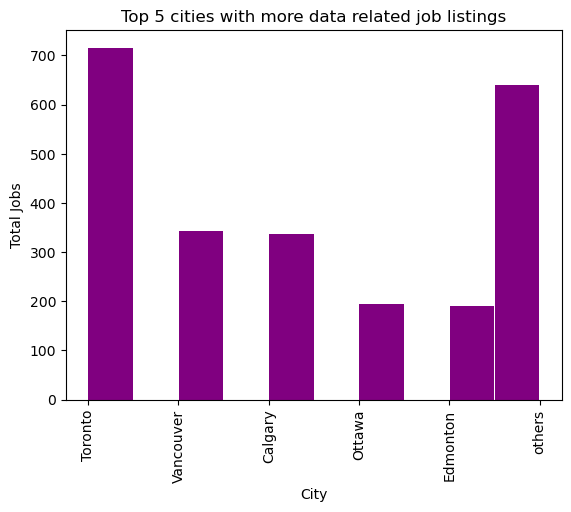

In [11]:
figure = plt.hist(cities, weights=counts,color='purple',rwidth=0.99)
plt.title('Top 5 cities with more data related job listings')
plt.xticks(rotation=90)
plt.ylabel('Total Jobs')
plt.xlabel('City')

plt.show()

## 3.3. K-means Clusters for Distinct Jobs

In [12]:
# Number of Unique Job Titles
len(df.title.unique())

1601

Because there are so many unique job titles, let's perform a clustering analysis to see if there is any number of similar jobs based on the job description, 


In [13]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


# Preprocess the data
df['description'] = df['description'].str.lower()  # convert to lower case
df['description'] = df['description'].str.replace('[^\w\s]','')  # remove punctuation

# Create TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['description'])



In [14]:

import matplotlib.pyplot as plt

# Create TF-IDF features (Measure that evaluates how relevant a word is to a document in a collection of documents)
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['description'])
# Calculate SSE for different K
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(10, 10))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters k')
plt.ylabel('Sum of squared distance')
plt.show()

c:\Users\juanc\anaconda3\envs\SpecialTopicsInData\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

Create the clustering and Assign labels

In [15]:
# Create a KMeans object and fit it to the data
kmeans = KMeans(n_clusters=8)  # choose the number of clusters based on the previous plot
kmeans.fit(X)

# Get the cluster assignments for each data point
df['cluster'] = kmeans.labels_

# Now, each job is assigned to a cluster. Jobs in the same cluster are more similar to each other than to jobs in other clusters.
# print the cluster and the job title
for e,i in df[['cluster','title']].values:
    print(f"cluster: {e}, title: {i}")

cluster: 6, title: Data Scientist
cluster: 7, title: Senior Data Scientist - Insights
cluster: 7, title: Data Scientist
cluster: 1, title: Data Scientist - Canada
cluster: 6, title: Lead Data Scientist
cluster: 6, title: Lead Data Scientist
cluster: 5, title: Lead Data Scientist - Investment Banking Analytics
cluster: 7, title: (CAN) Senior Manager, Data Science & Data Products
cluster: 7, title: Data Scientist-Full-Time
cluster: 6, title: Data Scientist - Data Analytics and Infrastructure
cluster: 7, title: Associate Data Scientist
cluster: 6, title: Data Scientist
cluster: 5, title: Senior Data Scientist
cluster: 5, title: Staff Data Scientist
cluster: 1, title: Bilingual Senior Data Scientist
cluster: 1, title: Senior Data Scientist for Product
cluster: 3, title: data scientist
cluster: 5, title: Data Scientist - Intern
cluster: 1, title: Data Scientist /ML Intern
cluster: 1, title: Data Scientist
cluster: 1, title: Staff Data Scientist
cluster: 7, title: Data Scientist
cluster: 1, 

### Plot the clusters in a scatter-plot

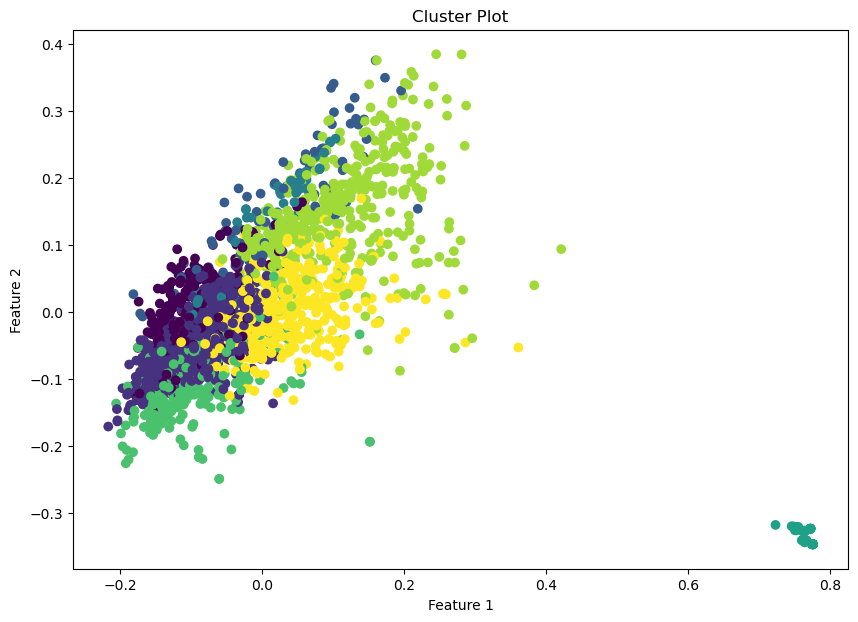

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce the TF-IDF (high dimensional data) features to two dimensions
pca = PCA(2)
reduced_features = pca.fit_transform(X.toarray())

# Add the reduced features to the dataframe
df['x'] = reduced_features[:,0]
df['y'] = reduced_features[:,1]

# Create a scatter plot of the reduced features, colored by cluster
plt.figure(figsize=(10, 7))
plt.scatter(df['x'], df['y'], c=df['cluster'])
plt.title("Cluster Plot")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


## 3.4. Most In-Demand Jobs

### Most in Demand Jobs using regular expressions

In [17]:
from collections import Counter
import re

# Number of unique job title
print(f"Unique job titles:  {len(df.title.unique())}")

Job_titles = ['data scientist', 'data analyst', 'data engineer', 'machine learning', 'business intelligence', 'bi', 'data architect', 'Other']

# Convert to set for faster lookup
job_set = set(Job_titles)
counts = Counter()

for title in df['title']:
    title = title.lower()
    matched = False
    for idx, job in enumerate(job_set):
        if re.search(job, title):
            counts[job] += 1
            matched = True
    if not matched:
        counts['Other'] += 1

print(counts)


Unique job titles:  1601
Counter({'Other': 828, 'data analyst': 512, 'data engineer': 402, 'data scientist': 292, 'machine learning': 221, 'bi': 119, 'data architect': 79, 'business intelligence': 54})


### let's check the previous data in a plot

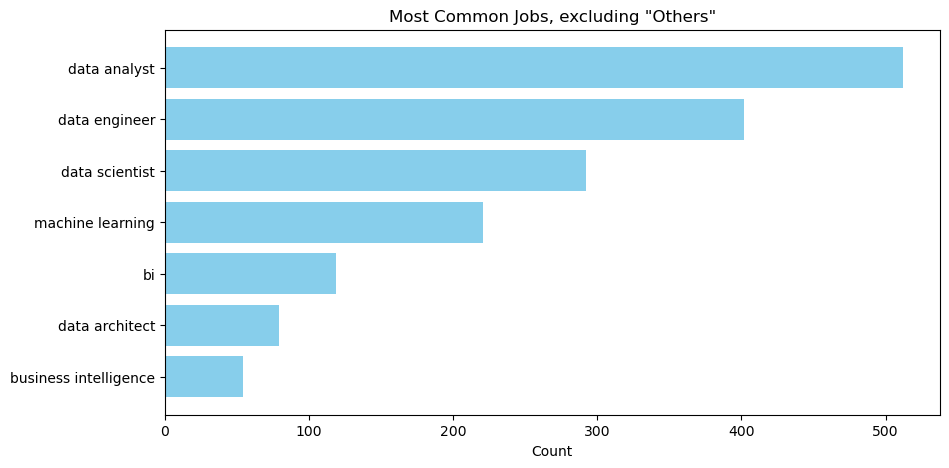

In [18]:
import matplotlib.pyplot as plt

# Get labels and values
labels, values = zip(*counts.items())

# Convert labels and values to lists for manipulation
labels = list(labels)
values = list(values)

# Check if 'Other' is in labels and remove it
if 'Other' in labels:
    index = labels.index('Other')
    labels.pop(index)
    values.pop(index)

# Sort values and labels by the counts
labels, values = zip(*sorted(zip(labels, values), key=lambda x: x[1]))

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Count')
plt.title('Most Common Jobs, excluding "Others"')
plt.show()

## 3.5. Job Types Distribution

### Verify the number of jobs per type

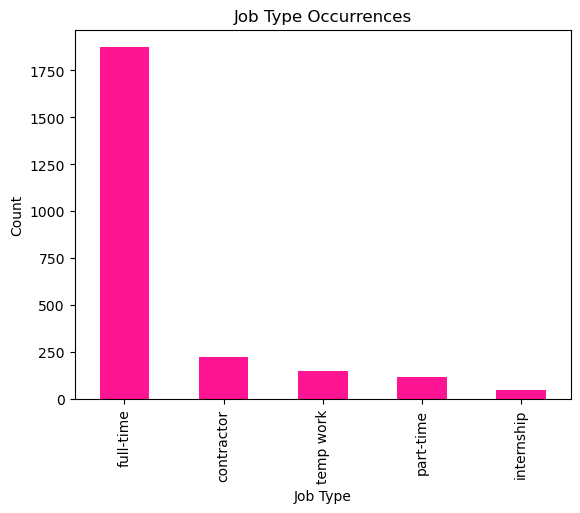

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the job types
job_types = ['full-time', 'part-time', 'internship', 'contractor', 'temp work']

# Create a new column 'job_type_standard' to standardize the job types
df['job_type_standard'] = ''

for job in job_types:
    df.loc[df['jobType'].str.contains(job, case=False, na=False), 'job_type_standard'] = job

# Exclude the rows with an empty 'job_type_standard'
df_filtered = df[df['job_type_standard'] != '']

# Count the occurrences of each job type
job_counts = df_filtered['job_type_standard'].value_counts()

# Plot a histogram
job_counts.plot(kind='bar', color='deeppink')
plt.title('Job Type Occurrences')
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.show()



### Now, let's plot the proportions among the different job types

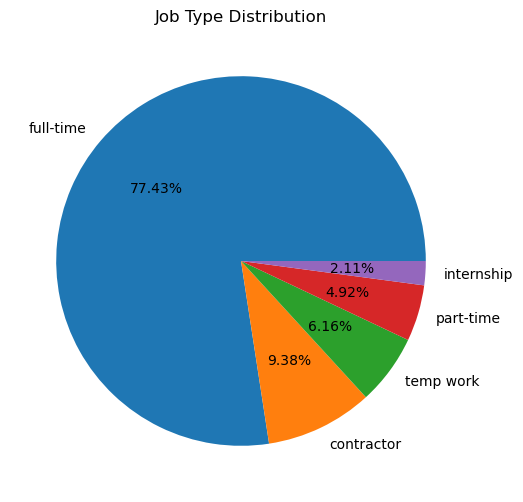

In [20]:
# Plot a pie chart
plt.figure(figsize=(10, 6))
plt.pie(job_counts, labels = job_counts.index, autopct='%1.2f%%')
plt.title('Job Type Distribution')
plt.show()

## 3.6. Top In-Demand Skills

Using NKLTK library to get the Technical skills in the job description 

In [87]:

# List of technical skills
technical_skills = ['python', 'r', 'sql','ai','c/c++', 'c','chat-gpt' 'hadoop', 'spark','api', 'java', 'scala','aws', 'azure', 'gcp', 'tableau', 'powerbi','power bi' 'excel', 'sas', 'spss', 'matlab', 'tensorflow', 'keras', 'pytorch', 'scikit-learn', 'pandas', 'numpy', 'matplotlib', 'seaborn', 'statistics', 'machine learning', 'deep learning', 'nlp', 'computer vision', 'data cleaning', 'data visualization', 'data mining', 'big data', "rest-api's"]

# Convert the list to a set for faster lookup
technical_skills_set = set(technical_skills)

# Initialize a Counter object to store the counts
counts = Counter()

# Process each job description
for description in df['description']:
    if isinstance(description, str):
        # Convert the description to lowercase
        description = description.lower()

        # Check for multi-word skills in the description
        for skill in technical_skills:
            if (' ' or '-') in skill and skill in description:
                counts[skill] += 1

        # Tokenize the text
        words = nltk.word_tokenize(description.lower())
     
        # Remove stopwords
        words = [word for word in words if word not in stopwords.words('english')]
    
        # Count the technical skills
        for word in words:
            if word in technical_skills_set:
                counts[word] += 1

# Get the most common technical skills
common_skills = counts.most_common(15)

# Separate the skills and counts into two lists
skills, counts = zip(*common_skills)





### Create a bar plot

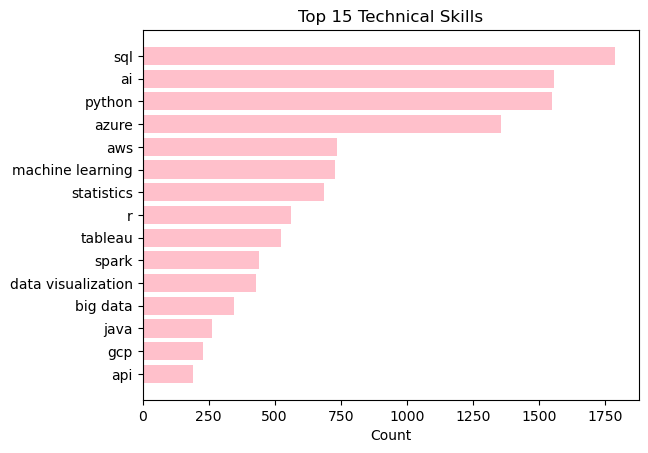

sql: 1789
ai: 1558
python: 1549
azure: 1358
aws: 737
machine learning: 727
statistics: 688
r: 562
tableau: 522
spark: 440
data visualization: 429
big data: 346
java: 263
gcp: 229
api: 190


In [88]:
# Create a bar plot of the skill counts
plt.barh(skills, counts, color='pink')
plt.xlabel('Count')
plt.title('Top 15 Technical Skills')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()

# Print the most common technical skills
for skill, count in common_skills:
    print(f'{skill}: {count}')

## 3.7. Years of Experience


In [89]:
experience_years = []

# Define a regex pattern to match years of experience (including range)
pattern_experience = r'\d+(\s*to\s*\d+)?\s*(\+|to)?\s*(years|year)'
# Additional condition: regex pattern to match 'experience' or 'experiences'
pattern_sentence = r'\b(experience|experiences)\b'

for description in df['description']:
    # Check if the description is a string
    if isinstance(description, str):
        # Find all matches for years of experience in the description
        matches_experience = re.finditer(pattern_experience, description, flags=re.IGNORECASE)
        
        for match in matches_experience:
            start_index = match.start()
            end_index = match.end()
            window_text = description[max(0, start_index - 30): min(len(description), end_index + 30)]
            
            # Check if 'experience' or 'experiences' is within the window
            if re.search(pattern_sentence, window_text, flags=re.IGNORECASE):
                experience_years.append(match.group(0))
                break  # Break the loop after finding the first match
        else:
            experience_years.append(None)  # If no match found, append None
    else:
        experience_years.append(None)


# Add the extracted years of experience as a new column in the DataFrame
df['years_experience'] = experience_years
df

,title,company,description,location,jobID,jobType,salary,platform,posting_date,City,Province,cluster,x,y,job_type_standard,years_experience
0,Data Scientist,AdventInfotech,data scientist:\n\nwe are seeking a highly mot...,"Vancouver, BC",M5XBjZtTkQ_D8mxYAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-15,Vancouver,BC,0,0.008149,-0.007559,full-time,None
1,Senior Data Scientist - Insights,Coursera,coursera was launched in 2012 by two stanford ...,Canada,VT_hfGMEKBPSIjP0AAAAAA%3D%3D,Full-time,NaN,Careers At Coursera,2024-03-14,Canada,Canada,2,-0.008708,-0.067315,full-time,4+ years
2,Data Scientist,Why Hiring,"at why hiring, we believe in the power of conn...",Canada,mTH8GfFTq4sMk_mCAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-14,Canada,Canada,5,-0.026031,0.116819,full-time,None
3,Data Scientist - Canada,Coinbase,"at coinbase, our mission is to increase econom...","Toronto, ON",8CWTyYjpHwEtZznAAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-16,Toronto,ON,2,-0.082297,-0.065456,full-time,5+ years
4,Lead Data Scientist,Equifax,do you have a passion for being at the forefro...,"Toronto, ON",38aVIkOwDVpGyeUkAAAAAA%3D%3D,Full-time,NaN,Equifax Careers,NaN,Toronto,ON,4,0.130843,0.042296,full-time,3+ years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,Consulting Statistician,Alimentiv,as a member of alimentiv’s statistical center ...,"Toronto, ON (+6 others)",PgXdRxVlbJ3tG6zwAAAAAA%3D%3D,Full-time,NaN,Lever,NaN,Toronto,ON (+6 others),2,-0.054769,-0.115331,full-time,6 years
2368,Interpretation Officer/Coordinator,Statistics Canada,interpretation officer / coordinator\n\nrefere...,"Sault Ste. Marie, ON",Q-IqsHbepldOkjSXAAAAAA%3D%3D,Full-time,NaN,Talent.com,NaN,Sault Ste. Marie,ON,6,-0.154927,-0.102124,full-time,None
2421,Solutions Architect,ClickJobs.io,this is a permanent role. they have to be loca...,"Winnipeg, MB",J2T7mXUa-HAGLkRpAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-23,Winnipeg,MB,5,-0.061813,-0.008614,full-time,10 years
2447,Senior Solutions Architect,Wellington-Altus Private Wealth Inc.,location: this position will be located in cal...,"Winnipeg, MB",JKKExOLfLVls17xEAAAAAA%3D%3D,Full-time,NaN,Jooble,2024-03-13,Winnipeg,MB,5,-0.145281,-0.030535,full-time,15+ years


In [90]:
non_null_indices = len(df[df['years_experience'].notnull()].index.tolist())
non_null_indices

1306

In [91]:
years_experience_list = df['years_experience'].dropna().tolist()
print(years_experience_list)

['4+ years', '5+ years', '3+ years', '5 years', '5+ years', '8+ years', '3+ years', '4+ years', '5 to 10 years', '3 years', '5 years', '3+ years', '3 years', '5+ years', '3+ years', '5+ years', '5 years', '5+ years', '5 years', '2+ years', '3 years', '1 year', '2 years', '5 years', '5 years', '2+ years', '5 years', '2 years', '3+ years', '5+ years', '1+ years', '3+ years', '1 year', '5+ years', '6+ years', '4+ years', '8 years', '5+ years', '1 year', '8+ years', '3+ years', '5 years', '2 years', '3 years', '3+ years', '5 years', '2 years', '3+ years', '2 years', '2+ years', '2 years', '2 years', '5 years', '5 years', '5+ years', '3+ years', '5+ years', '5+ years', '4 years', '5+ years', '3+ years', '3+ years', '8+ years', '5+ years', '3+ years', '9+ years', '5+ years', '7+ years', '5+ years', '4+ years', '4 years', '5+ years', '3+ years', '1+ years', '5+ years', '4 years', '5+ years', '10+ years', '5 years', '5+ years', '1+ years', '2+ years', '4+ years', '3+ years', '10+ years', '3+ y

Clean the years_experience column. If it is a range, we will take the minimum value.

In [92]:
import numpy as np

# Function to clean the years_experience values
def clean_years_experience(years):
    if years is None:
        return np.nan
    
    years = str(years)  # Convert to string
    years = years.lower()  # Convert to lowercase
    
    if '-' in years or 'to' in years:  # If it's a range (e.g., 5 to 10 years)
        if '-' in years:
            years = years.split('-')[0]  # Take the minimum value before the dash
        elif 'to' in years:
            years = years.split('to')[0].strip()  # Take the minimum value before 'to'
            
    years = re.sub('[^\d\+]', '', years)  # Keep only digits and plus sign
    
    if years.isnumeric():  # If it's a single number without plus sign
            years = str(years) + '+'  # Add the plus sign 
    
    return years

# Apply the cleaning function to create the new column
df['years_experience_cleaned'] = df['years_experience'].apply(clean_years_experience)
df

,title,company,description,location,jobID,jobType,salary,platform,posting_date,City,Province,cluster,x,y,job_type_standard,years_experience,years_experience_cleaned
0,Data Scientist,AdventInfotech,data scientist:\n\nwe are seeking a highly mot...,"Vancouver, BC",M5XBjZtTkQ_D8mxYAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-15,Vancouver,BC,0,0.008149,-0.007559,full-time,None,NaN
1,Senior Data Scientist - Insights,Coursera,coursera was launched in 2012 by two stanford ...,Canada,VT_hfGMEKBPSIjP0AAAAAA%3D%3D,Full-time,NaN,Careers At Coursera,2024-03-14,Canada,Canada,2,-0.008708,-0.067315,full-time,4+ years,4+
2,Data Scientist,Why Hiring,"at why hiring, we believe in the power of conn...",Canada,mTH8GfFTq4sMk_mCAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-14,Canada,Canada,5,-0.026031,0.116819,full-time,None,NaN
3,Data Scientist - Canada,Coinbase,"at coinbase, our mission is to increase econom...","Toronto, ON",8CWTyYjpHwEtZznAAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-16,Toronto,ON,2,-0.082297,-0.065456,full-time,5+ years,5+
4,Lead Data Scientist,Equifax,do you have a passion for being at the forefro...,"Toronto, ON",38aVIkOwDVpGyeUkAAAAAA%3D%3D,Full-time,NaN,Equifax Careers,NaN,Toronto,ON,4,0.130843,0.042296,full-time,3+ years,3+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,Consulting Statistician,Alimentiv,as a member of alimentiv’s statistical center ...,"Toronto, ON (+6 others)",PgXdRxVlbJ3tG6zwAAAAAA%3D%3D,Full-time,NaN,Lever,NaN,Toronto,ON (+6 others),2,-0.054769,-0.115331,full-time,6 years,6+
2368,Interpretation Officer/Coordinator,Statistics Canada,interpretation officer / coordinator\n\nrefere...,"Sault Ste. Marie, ON",Q-IqsHbepldOkjSXAAAAAA%3D%3D,Full-time,NaN,Talent.com,NaN,Sault Ste. Marie,ON,6,-0.154927,-0.102124,full-time,None,NaN
2421,Solutions Architect,ClickJobs.io,this is a permanent role. they have to be loca...,"Winnipeg, MB",J2T7mXUa-HAGLkRpAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-23,Winnipeg,MB,5,-0.061813,-0.008614,full-time,10 years,10+
2447,Senior Solutions Architect,Wellington-Altus Private Wealth Inc.,location: this position will be located in cal...,"Winnipeg, MB",JKKExOLfLVls17xEAAAAAA%3D%3D,Full-time,NaN,Jooble,2024-03-13,Winnipeg,MB,5,-0.145281,-0.030535,full-time,15+ years,15+


In [93]:
years_experience_list = df['years_experience_cleaned'].dropna().tolist()
print(years_experience_list)

['4+', '5+', '3+', '5+', '5+', '8+', '3+', '4+', '5+', '3+', '5+', '3+', '3+', '5+', '3+', '5+', '5+', '5+', '5+', '2+', '3+', '1+', '2+', '5+', '5+', '2+', '5+', '2+', '3+', '5+', '1+', '3+', '1+', '5+', '6+', '4+', '8+', '5+', '1+', '8+', '3+', '5+', '2+', '3+', '3+', '5+', '2+', '3+', '2+', '2+', '2+', '2+', '5+', '5+', '5+', '3+', '5+', '5+', '4+', '5+', '3+', '3+', '8+', '5+', '3+', '9+', '5+', '7+', '5+', '4+', '4+', '5+', '3+', '1+', '5+', '4+', '5+', '10+', '5+', '5+', '1+', '2+', '4+', '3+', '10+', '3+', '3+', '5+', '5+', '5+', '5+', '5+', '5+', '2+', '3+', '2+', '1+', '2+', '3+', '3+', '5+', '2+', '4+', '10+', '1+', '7+', '2+', '5+', '8+', '2+', '3+', '5+', '5+', '5+', '3+', '2+', '3+', '4+', '5+', '7+', '2+', '3+', '3+', '2+', '3+', '3+', '5+', '5+', '5+', '6+', '5+', '5+', '5+', '3+', '2+', '2+', '5+', '3+', '10+', '3+', '3+', '5+', '5+', '2+', '4+', '5+', '4+', '5+', '4+', '3+', '5+', '5+', '4+', '2+', '6+', '2+', '3+', '3+', '3+', '5+', '3+', '6+', '8+', '3+', '5+', '5+',

Remove error extraction

In [94]:
df['years_experience_cleaned'] = df['years_experience_cleaned'].replace(['60+', '30+','35+'], None)

In [95]:
non_null_indices = len(df[df['years_experience_cleaned'].notnull()].index.tolist())
non_null_indices

1299

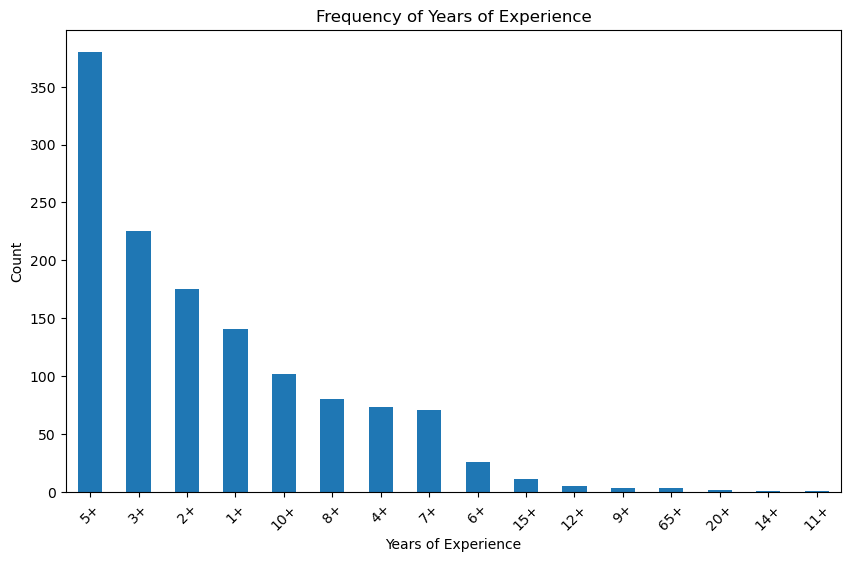

In [96]:
import matplotlib.pyplot as plt

# Remove NaN values from the 'years_experience_cleaned' column
cleaned_years_filtered = df['years_experience_cleaned'].dropna()

# Count the frequency of each value in the 'years_experience_cleaned' column
value_counts = cleaned_years_filtered.value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.xlabel('Years of Experience')
plt.ylabel('Count')
plt.title('Frequency of Years of Experience')
plt.xticks(rotation=45)
plt.show()


## 3.8. Education Requirements

### Extract education requirements
Bachelor/master/phd/doctorate/diploma

In [97]:
def extract_education_requirements(description):
    if not isinstance(description, str):
        return None
    
    # Convert the description to lowercase for case-insensitive matching
    description = description.lower()
    
    # Define regular expressions patterns to match common education keywords
    patterns = [
    r'\b(education|degree|qualification|diploma)[\w\s:]*\b(bachelor|b\.?s\.?|master|msc|m\.?s\.?|phd|doctorate)\b',
    r'\b(bachelor|b\.?s\.?|master|msc|m\.?s\.?|phd|doctorate)[\w\s:]*\b(education|degree|qualification|diploma)\b'
    ]
    
    education_requirements = []
    
    # Iterate over the patterns and find matches in the description
    for pattern in patterns:
        matches = re.findall(pattern, description)
        for match in matches:
            education_requirements.append(match[1])
    
    # Remove duplicate education requirements and return as a list
    education_requirements = list(set(education_requirements))

    if not education_requirements:  # If the list is empty, return NaN
      return np.nan
    
    return education_requirements

df['edu_requirements'] = df['description'].apply(extract_education_requirements)
df

,title,company,description,location,jobID,jobType,salary,platform,posting_date,City,Province,cluster,x,y,job_type_standard,years_experience,years_experience_cleaned,edu_requirements
0,Data Scientist,AdventInfotech,data scientist:\n\nwe are seeking a highly mot...,"Vancouver, BC",M5XBjZtTkQ_D8mxYAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-15,Vancouver,BC,0,0.008149,-0.007559,full-time,None,NaN,NaN
1,Senior Data Scientist - Insights,Coursera,coursera was launched in 2012 by two stanford ...,Canada,VT_hfGMEKBPSIjP0AAAAAA%3D%3D,Full-time,NaN,Careers At Coursera,2024-03-14,Canada,Canada,2,-0.008708,-0.067315,full-time,4+ years,4+,NaN
2,Data Scientist,Why Hiring,"at why hiring, we believe in the power of conn...",Canada,mTH8GfFTq4sMk_mCAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-14,Canada,Canada,5,-0.026031,0.116819,full-time,None,NaN,NaN
3,Data Scientist - Canada,Coinbase,"at coinbase, our mission is to increase econom...","Toronto, ON",8CWTyYjpHwEtZznAAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-16,Toronto,ON,2,-0.082297,-0.065456,full-time,5+ years,5+,[degree]
4,Lead Data Scientist,Equifax,do you have a passion for being at the forefro...,"Toronto, ON",38aVIkOwDVpGyeUkAAAAAA%3D%3D,Full-time,NaN,Equifax Careers,NaN,Toronto,ON,4,0.130843,0.042296,full-time,3+ years,3+,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,Consulting Statistician,Alimentiv,as a member of alimentiv’s statistical center ...,"Toronto, ON (+6 others)",PgXdRxVlbJ3tG6zwAAAAAA%3D%3D,Full-time,NaN,Lever,NaN,Toronto,ON (+6 others),2,-0.054769,-0.115331,full-time,6 years,6+,NaN
2368,Interpretation Officer/Coordinator,Statistics Canada,interpretation officer / coordinator\n\nrefere...,"Sault Ste. Marie, ON",Q-IqsHbepldOkjSXAAAAAA%3D%3D,Full-time,NaN,Talent.com,NaN,Sault Ste. Marie,ON,6,-0.154927,-0.102124,full-time,None,NaN,NaN
2421,Solutions Architect,ClickJobs.io,this is a permanent role. they have to be loca...,"Winnipeg, MB",J2T7mXUa-HAGLkRpAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-23,Winnipeg,MB,5,-0.061813,-0.008614,full-time,10 years,10+,NaN
2447,Senior Solutions Architect,Wellington-Altus Private Wealth Inc.,location: this position will be located in cal...,"Winnipeg, MB",JKKExOLfLVls17xEAAAAAA%3D%3D,Full-time,NaN,Jooble,2024-03-13,Winnipeg,MB,5,-0.145281,-0.030535,full-time,15+ years,15+,NaN


In [98]:
years_experience_list = [item for item in df['edu_requirements'].dropna().tolist() if item]
print(years_experience_list)

[['degree'], ['degree'], ['degree'], ['bachelor'], ['degree'], ['master'], ['bachelor'], ['phd', 'degree'], ['bachelor'], ['bachelor'], ['phd', 'degree'], ['degree'], ['bachelor'], ['degree'], ['bachelor'], ['doctorate', 'degree'], ['degree'], ['phd'], ['bachelor'], ['degree'], ['bachelor'], ['bachelor'], ['degree'], ['degree'], ['master'], ['bachelor'], ['degree'], ['bachelor'], ['bachelor'], ['degree'], ['bachelor'], ['bachelor'], ['bachelor'], ['bachelor'], ['degree'], ['phd', 'master'], ['degree'], ['degree'], ['bachelor'], ['bachelor'], ['bachelor'], ['bachelor'], ['bachelor'], ['bachelor'], ['bachelor'], ['bachelor'], ['degree'], ['master'], ['degree'], ['bachelor'], ['bachelor'], ['degree'], ['bachelor'], ['degree'], ['msc'], ['msc'], ['degree'], ['phd'], ['phd'], ['phd'], ['ms'], ['degree'], ['bachelor'], ['m.s'], ['degree'], ['degree'], ['bachelor'], ['phd', 'degree'], ['degree'], ['degree'], ['bachelor'], ['bachelor'], ['degree'], ['degree'], ['bachelor'], ['bachelor'], ['bac

Clean the edu_requirements column: We will change all the 'degree' to 'bachelor' for grouping the data better.

In [99]:
import numpy as np

def replace_msc_with_master(requirements):
       
    if isinstance(requirements, float):
        return np.nan  # Return NaN if requirements is a float
    
    cleaned_requirements = []
    
    # Check if the requirements list is empty
    if not requirements:
        return np.nan  # Return NaN if the list is empty
    
    for requirement in requirements:
        requirement = requirement.lower()
        if requirement in ['msc', 'ms', 'm.s']:
            cleaned_requirements.append('master')
        elif requirement == 'degree':
            cleaned_requirements.append('bachelor')
        else:
            cleaned_requirements.append(requirement)
    
    return cleaned_requirements

df['edu_requirements_cleaned'] = df['edu_requirements'].apply(replace_msc_with_master)
df


,title,company,description,location,jobID,jobType,salary,platform,posting_date,City,Province,cluster,x,y,job_type_standard,years_experience,years_experience_cleaned,edu_requirements,edu_requirements_cleaned
0,Data Scientist,AdventInfotech,data scientist:\n\nwe are seeking a highly mot...,"Vancouver, BC",M5XBjZtTkQ_D8mxYAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-15,Vancouver,BC,0,0.008149,-0.007559,full-time,None,NaN,NaN,NaN
1,Senior Data Scientist - Insights,Coursera,coursera was launched in 2012 by two stanford ...,Canada,VT_hfGMEKBPSIjP0AAAAAA%3D%3D,Full-time,NaN,Careers At Coursera,2024-03-14,Canada,Canada,2,-0.008708,-0.067315,full-time,4+ years,4+,NaN,NaN
2,Data Scientist,Why Hiring,"at why hiring, we believe in the power of conn...",Canada,mTH8GfFTq4sMk_mCAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-14,Canada,Canada,5,-0.026031,0.116819,full-time,None,NaN,NaN,NaN
3,Data Scientist - Canada,Coinbase,"at coinbase, our mission is to increase econom...","Toronto, ON",8CWTyYjpHwEtZznAAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-16,Toronto,ON,2,-0.082297,-0.065456,full-time,5+ years,5+,[degree],[bachelor]
4,Lead Data Scientist,Equifax,do you have a passion for being at the forefro...,"Toronto, ON",38aVIkOwDVpGyeUkAAAAAA%3D%3D,Full-time,NaN,Equifax Careers,NaN,Toronto,ON,4,0.130843,0.042296,full-time,3+ years,3+,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,Consulting Statistician,Alimentiv,as a member of alimentiv’s statistical center ...,"Toronto, ON (+6 others)",PgXdRxVlbJ3tG6zwAAAAAA%3D%3D,Full-time,NaN,Lever,NaN,Toronto,ON (+6 others),2,-0.054769,-0.115331,full-time,6 years,6+,NaN,NaN
2368,Interpretation Officer/Coordinator,Statistics Canada,interpretation officer / coordinator\n\nrefere...,"Sault Ste. Marie, ON",Q-IqsHbepldOkjSXAAAAAA%3D%3D,Full-time,NaN,Talent.com,NaN,Sault Ste. Marie,ON,6,-0.154927,-0.102124,full-time,None,NaN,NaN,NaN
2421,Solutions Architect,ClickJobs.io,this is a permanent role. they have to be loca...,"Winnipeg, MB",J2T7mXUa-HAGLkRpAAAAAA%3D%3D,Full-time,NaN,LinkedIn,2024-03-23,Winnipeg,MB,5,-0.061813,-0.008614,full-time,10 years,10+,NaN,NaN
2447,Senior Solutions Architect,Wellington-Altus Private Wealth Inc.,location: this position will be located in cal...,"Winnipeg, MB",JKKExOLfLVls17xEAAAAAA%3D%3D,Full-time,NaN,Jooble,2024-03-13,Winnipeg,MB,5,-0.145281,-0.030535,full-time,15+ years,15+,NaN,NaN


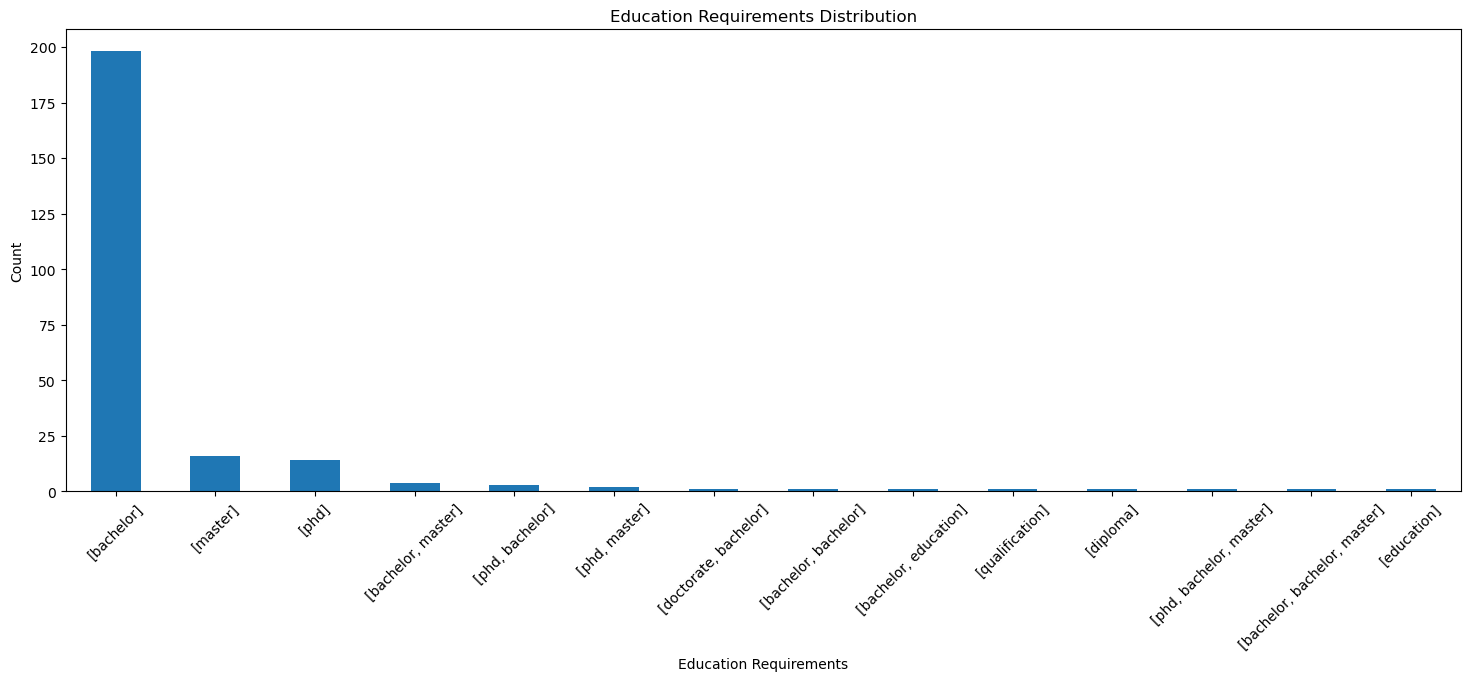

In [100]:
import matplotlib.pyplot as plt

# Filter out empty lists from the 'edu_requirements' column
non_empty_edu_requirements = df['edu_requirements_cleaned'].apply(lambda x: x if x else None).dropna()

# Count the occurrences of each education requirement
edu_counts = non_empty_edu_requirements.value_counts()

# Plot the bar chart
plt.figure(figsize=(18, 6))
edu_counts.plot(kind='bar')
plt.xlabel('Education Requirements')
plt.ylabel('Count')
plt.title('Education Requirements Distribution')
plt.xticks(rotation=45)
plt.show()

 ## 3.9. Seniority Levels

### Extract seniority: "senior", "intermediate", "entry-level", "junior", "apprentice"

In [101]:
import re
import numpy as np

def extract_seniority_requirements(description):
    if description is None or isinstance(description, float):
        return None
    
    description = description.lower()  # Convert description to lowercase
    
    seniority_keywords = ["senior", "intermediate", "entry-level", "junior", "apprentice"]
    
    seniority_requirements = []
    
    for keyword in seniority_keywords:
        pattern = r"\b" + re.escape(keyword) + r"\b"
        matches = re.findall(pattern, description, flags=re.IGNORECASE)
        if matches:
            seniority_requirements.extend(matches)
    
    seniority_requirements = list(set(seniority_requirements))

    if not seniority_requirements:  # If the list is empty, return NaN
      return np.nan
    
    return seniority_requirements

df['seniority'] = df['description'].apply(extract_seniority_requirements)
df['seniority']


0                                  NaN
1                                  NaN
2                                  NaN
3                             [senior]
4       [junior, intermediate, senior]
                     ...              
2348                               NaN
2368                               NaN
2421                          [senior]
2447                          [senior]
2453                               NaN
Name: seniority, Length: 2420, dtype: object

In [102]:
seniority_list = [item for item in df['seniority'].dropna().tolist() if item]
print(seniority_list)

[['senior'], ['junior', 'intermediate', 'senior'], ['senior'], ['senior'], ['senior'], ['senior'], ['senior'], ['senior'], ['senior'], ['senior'], ['senior'], ['intermediate'], ['senior'], ['senior'], ['senior'], ['senior'], ['senior'], ['junior', 'intermediate'], ['junior'], ['junior', 'senior'], ['senior'], ['senior'], ['senior'], ['junior', 'senior'], ['senior'], ['senior'], ['senior'], ['senior'], ['senior'], ['senior'], ['junior', 'senior'], ['junior', 'entry-level', 'senior'], ['senior'], ['senior'], ['senior'], ['senior'], ['junior', 'senior'], ['junior', 'senior'], ['senior'], ['senior'], ['junior'], ['senior'], ['senior'], ['senior'], ['senior'], ['senior'], ['intermediate'], ['senior'], ['intermediate', 'senior'], ['intermediate'], ['senior'], ['senior'], ['senior'], ['senior'], ['junior'], ['senior'], ['senior'], ['senior'], ['junior'], ['senior'], ['junior'], ['senior'], ['senior'], ['senior'], ['intermediate'], ['junior', 'intermediate', 'senior'], ['senior'], ['senior'], 

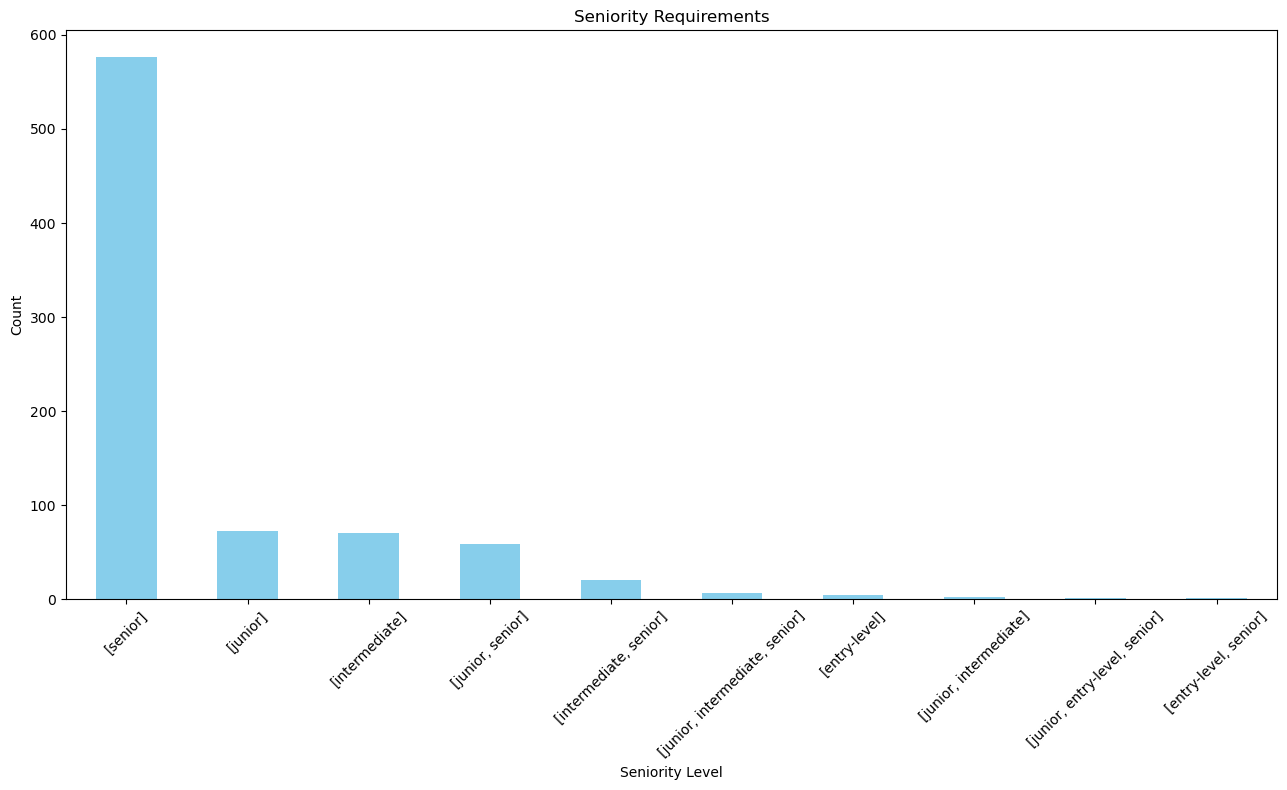

In [103]:
seniority_counts = df['seniority'].value_counts()

# Plotting
plt.figure(figsize=(13, 8))
seniority_counts.plot(kind='bar', color='skyblue')
plt.title('Seniority Requirements')
plt.xlabel('Seniority Level')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


# 4. **Salary Exploration (Descriptive)**

## 4.1. Salary Cleaning

 ### 4.1.1. Using Regular Expressions

### Extracting the salary from the job description, using Regular Expressions

In [104]:

# Create a new list to store the salaries
salaries = []

# Define a regex pattern to match salary, left and right hand sides to the hyphen try to match money formatted values
# The pattern includes an optional group for the thousands separator and the '—' character as a possible separator
# It also includes optional groups to capture the frequency of the salary

# best pattern found
pattern = r'\$\d{1,3}(?:[,\s]\d{3})*(\.\d+)?(?:K)?\s*(CAD|US|\(US\))?\s*[-—]\s*\$\d{1,3}(?:[,\s]\d{3})*(\.\d+)?(?:K)?\s*(CAD|US|\(US\)|\(CAD\))?\s*((per hour|/\s*hour|per year|/s*year|month|hourly|annually|monthly|\\h|/\s*h))?'


# Process each job description
for description in df['description']:
    # Check if the description is a string
    if isinstance(description, str):
        # Find all salary matches in the description
        matches = re.search(pattern, description)
        # If matches were found, add them to the salaries list
        if matches:
            salaries.append(matches.group())
        else:
            salaries.append(None)
    else:
        salaries.append(None)

# Add the salaries as a new column in the DataFrame
df['salary_range_regex'] = salaries

print("New Salaries Found using Regular expressions: ", len(df[df['salary_range_regex'].notna()]['salary_range_regex']))


New Salaries Found using Regular expressions:  279


### Cleaning the Salary Column

In [105]:

# Checking the different types in the 'salary'
df['salary'].apply(type).value_counts()


salary
<class 'float'>    2128
<class 'str'>       292
Name: count, dtype: int64

So we have mixed data, str and float, the plan is to convert everything first to str, clean it and then convert back to float.

Let's see if there is meaningful information in the float values:

In [106]:
sum_salaries=0
for elem in df['salary']:
    if type(elem)==float:
        sum_salaries = sum_salaries + elem
print(sum_salaries)


nan


So all the data that we care are those in the 'str' type

### Create a Function to convert the  Extracted Salary Data

In [107]:
import pandas as pd

def clean_data(salary):
    if isinstance(salary, float):
        return pd.Series([0, 0, "No data"])
    
    conversion_rate = 1.36 if "US$" in salary else 1
    salary = salary.replace("US$", "").replace("$", "").lower()

    if "an hour" in salary:
        salary_type = "hourly"
        salary = salary.replace("an hour", "")
    elif "a month" in salary:
        salary_type = "monthly"
        salary = salary.replace("a month", "")
    elif "a day" in salary:
        salary_type = 'daily'
        salary = salary.replace("a day", "")
    elif "a week" in salary:
        salary_type = 'weekly'
        salary = salary.replace("a week", "")
    elif "a year" in salary:
        salary_type = "annual"
        salary = salary.replace("a year", "")
    
    # Remove decimal values before 'K'
    if '.' in salary and 'k' in salary:
        salary = salary.replace('.', '')
    salary = salary.replace("k", "000")

    if "–" in salary:
        low, high = salary.split("–")
        low = float(low.replace(",", "")) * conversion_rate
        high = float(high.replace(",", "")) * conversion_rate
    else:
        low = high = float(salary.replace(",", "")) * conversion_rate

    return pd.Series([low, high, salary_type])


### Apply the cleaning function 

In [108]:
for e in df[df['salary'].notna()]['salary']:
    print(e)

US$130K a year
$150K a year
$68,974.70–$86,218.40 a year
US$80K–US$100K a year
$51–$63 an hour
US$86.6K–US$166K a year
$42K–$78K a year
US$65K–US$80K a year
US$97,574–US$140,940 a year
$95K–$170K a year
$85K–$90K a year
US$120K–US$190K a year
$95K–$170K a year
US$65,750–US$108,000 a year
$95K–$170K a year
$45–$75 an hour
$95K–$170K a year
$55K a year
US$120K–US$150K a year
$115K–$125K a year
$84K–$144K a year
$51.4K–$95.2K a year
$70K–$85K a year
US$66,820–US$106,875 a year
$60,000–$102,008 a year
$53.8K–$87.4K a year
$51.4K–$95.2K a year
US$68,750–US$110,000 a year
$130K–$200K a year
$80K–$95K a year
$80K–$120K a year
$80K–$90K a year
US$55–US$60 an hour
$70K–$100K a year
$29.66–$37.47 an hour
$65K a year
$45–$50 an hour
$55K–$65K a year
$110K–$120K a year
US$116,047–US$193,412 a year
$46.64 an hour
$70–$75 an hour
$67,619.03–$105,000.00 a year
$67,712–$146,632 a year
$70–$100 an hour
$150K a year
$60K–$110K a year
$95K–$110K a year
$70–$80 an hour
US$60–US$65 an hour
$125K–$175K a ye

In [109]:
# Apply function to 'salary' column
df[['low', 'high', 'salary_type']] = df['salary'].apply(clean_data)

Let's check the output of the function 

In [110]:
for a,b,c in df[df['salary_type']!='No data'][['low', 'high', 'salary_type']].values:
    print(f"low: {a}, high: {b}, type: {c}")

low: 176800.0, high: 176800.0, type: annual
low: 150000.0, high: 150000.0, type: annual
low: 68974.7, high: 86218.4, type: annual
low: 108800.00000000001, high: 136000.0, type: annual
low: 51.0, high: 63.0, type: hourly
low: 1177760.0, high: 225760.00000000003, type: annual
low: 42000.0, high: 78000.0, type: annual
low: 88400.0, high: 108800.00000000001, type: annual
low: 132700.64, high: 191678.40000000002, type: annual
low: 95000.0, high: 170000.0, type: annual
low: 85000.0, high: 90000.0, type: annual
low: 163200.0, high: 258400.00000000003, type: annual
low: 95000.0, high: 170000.0, type: annual
low: 89420.0, high: 146880.0, type: annual
low: 95000.0, high: 170000.0, type: annual
low: 45.0, high: 75.0, type: hourly
low: 95000.0, high: 170000.0, type: annual
low: 55000.0, high: 55000.0, type: annual
low: 163200.0, high: 204000.00000000003, type: annual
low: 115000.0, high: 125000.0, type: annual
low: 84000.0, high: 144000.0, type: annual
low: 514000.0, high: 952000.0, type: annual
l

### Now we calculate the average annual Salary

Let's define a Function to calculate it based on the low, high and salary_type fields

In [111]:
def  get_average_salary(row):
    low, high, salary_type = row['low'], row['high'], row['salary_type']

    avg = (low + high) / 2 
    if salary_type == "hourly":
        # hours per week and working weeks
        avg *= 40 * 48
    elif salary_type == "weekly":
        # working weeks in a year
        avg *= 48
    elif salary_type == "monthly":
        # months per year
        avg *= 12
    elif salary_type == "daily":
        # average estimated working days in a year 
        avg *= 254
    #If there was a mistake in the hours/annual salary type, correct it:
    if(avg<1000):
        avg = avg*1000
    return pd.Series([avg])


Apply the function to the DataFrame and calculate the average

In [112]:

df['avg_salary'] = df.apply(get_average_salary, axis=1)


df['avg_salary'] = df[['low', 'high', 'salary_type']].apply(get_average_salary, axis=1)

### Check the Output

In [113]:

for e in df[df['avg_salary']!=0.0]["avg_salary"]:
    print(e)

176800.0
150000.0
77596.54999999999
122400.0
109440.0
701760.0
60000.0
98600.0
162189.52000000002
132500.0
87500.0
210800.0
132500.0
118150.0
132500.0
115200.0
132500.0
55000.0
183600.0
120000.0
114000.0
733000.0
77500.0
118112.6
81004.0
706000.0
733000.0
121550.0
165000.0
87500.0
100000.0
85000.0
150144.00000000003
85000.0
64444.799999999996
65000.0
91200.0
60000.0
115000.0
210432.12
89548.8
139200.0
86309.515
107172.0
163200.0
150000.0
85000.0
102500.0
144000.0
163200.0
150000.0
251600.00000000003
273360.0
74270.0
132500.0
220000.0
116500.0
110000.0
124000.0
191832.0
175000.0
256500.0
269000.0
218500.0
96000.0
160000.0
125456.0
124440.0
125000.0
95000.0
160000.0
135321.59999999998
122400.0
100000.0
105000.0
100083.5
80000.0
109000.0
76167.0
75000.0
82500.0
100713.59999999999
82500.0
38726.4
105439.84999999999
112577.0
171000.0
117790.96
55680.0
92160.0
71810.0
115000.0
182960.0
103286.40000000001
82366.5
100000.0
78336.00000000001
141000.0
277000.0
175000.0
175000.0
120000.0
158000.0

### Now we need to  Calculate Average Salary for the extracted salaries from the Job descriptions

We know they are not that many, Let's check the values

In [114]:
salaryList = (df[df['salary_range_regex'].notna()]['salary_range_regex'])
for element in salaryList:
    print(element)
    print('-'*40)

len(df[df['salary_range_regex'].notna()]['salary_range_regex'])

$149,500—$149,500 
----------------------------------------
$80,718.42 - $93,540.00 
----------------------------------------
$149,500—$149,500 
----------------------------------------
$63.63 - $91.47 / hour
----------------------------------------
$110,000 - $140,000 
----------------------------------------
$51.00 - $63.00 per hour
----------------------------------------
$57.83 - $83.13 / hour
----------------------------------------
$101,804 - $137,736


----------------------------------------
$45-$75/h
----------------------------------------
$160,000 - $200,000
----------------------------------------
$226,000 - $281,000/year
----------------------------------------
$140,000 - $165,000 
----------------------------------------
$150,000—$165,000 
----------------------------------------
$120,000—$130,000 
----------------------------------------
$130,250 - $199,400 
----------------------------------------
$110.000 - $175.000 per year
----------------------------------------
$11

279

### Now we create a function to get the salary ranges cleaned

In [115]:
import re
import pandas as pd

def clean_salary_column(row):
    is_us = False
    # save the salary range
    low, high, salary_range, salary_type = row['low'], row['high'], row['salary_range_regex'], row['salary_type']
    
    if(isinstance(salary_range,str)):
        
        salary_type  ='annual'
        
        # Check if the value is in $ US
        def check_US(salary_range):
            nonlocal is_us
            if isinstance(salary_range,str):
                if "US" in salary_range:
                    return True
                else: 
                    return False
        
        # Get the salary type
        def get_salary_type(salary):
            if re.search(r'hour|/h|\sh', salary, re.IGNORECASE) is not None:
                return 'hourly'
            elif re.search(r'day|daily', salary, re.IGNORECASE) is not None:
                return 'daily'
            elif re.search(r'year|annually|annual', salary, re.IGNORECASE) is not None:
                return 'annual'
            elif re.search(r'weekly', salary, re.IGNORECASE) is not None:
                return 'weekly'
            else:
                return 'annual'  # Default to annual if unable to determine

        
        # Convert $US to $CAD 
        def convert_currency(value):
            return value * 1.3
        
        # Split the range into high and low if there is 
        def split_into_range(salary_range):
            # only if it is a string
            if isinstance(salary_range, str):
                # Replace the long dash with a short one
                salary_range = salary_range.replace('—', '-')
                # Split the string on the dash
                parts = salary_range.split('-')
                # Remove any leading or trailing spaces from each part
                low = parts[0].strip()
                high = parts[1].strip() if len(parts) > 1 else low
                return [low, high] 

        # Try to get the amount in the string
        def get_value(amount):
            if isinstance(amount, str):
                amount = amount.replace('k', '000') # Replace 'k' with '000'
                amount = re.sub(r'[^\d.—-]', '', amount)  # Remove non-digit characters except dot and separators
                try:
                    amount = float(amount)
                    return amount
                except:
                    return None
            return amount
        
        # Main logic  of the function 

        # check if it is $US 
        is_us = check_US(salary_range)
        # Get salary type
        salary_type = get_salary_type(salary_range)
        #Split the salary
        low, high = split_into_range(salary_range=salary_range)
        # Get the amounts 
        low = get_value(low)
        high = get_value(high)
        #if it was $US dollars, transform, else do nothing else
        if is_us :
            low =  convert_currency(low)
            high = convert_currency(high)
    
   
    # If it was 0 in the first place
        if row['low'] ==0:
            return pd.Series([low, high, salary_type])
        else: 
            #Return the original values for salary
            return pd.Series([row['low'],row['high'], row['salary_type']]) 
    else:
        return pd.Series([low,high, salary_type]) 



In [116]:
df.columns

Index(['title', 'company', 'description', 'location', 'jobID', 'jobType',
       'salary', 'platform', 'posting_date', 'City', 'Province', 'cluster',
       'x', 'y', 'job_type_standard', 'years_experience',
       'years_experience_cleaned', 'edu_requirements',
       'edu_requirements_cleaned', 'seniority', 'salary_range_regex', 'low',
       'high', 'salary_type', 'avg_salary'],
      dtype='object')

### Apply the cleaning function to the 'salary_range_regex' column

In [117]:
df[['low','high','salary_type']]= df[['low', 'high','salary_range_regex', 'salary_type']].apply(clean_salary_column, axis=1)


### Checking the results

In [118]:
df[df['low']!=0.0][['salary','salary_range_regex','low','high','salary_type','avg_salary']]

,salary,salary_range_regex,low,high,salary_type,avg_salary
3,NaN,"$149,500—$149,500",149500.00,149500.00,annual,0.0
25,US$130K a year,None,176800.00,176800.00,annual,176800.0
26,NaN,"$80,718.42 - $93,540.00",80718.42,93540.00,annual,0.0
35,$150K a year,"$149,500—$149,500",150000.00,150000.00,annual,150000.0
36,NaN,$63.63 - $91.47 / hour,63.63,91.47,hourly,0.0
...,...,...,...,...,...,...
1999,US$100K–US$143K a year,None,136000.00,194480.00,annual,165240.0
2294,$91K–$194K a year,None,91000.00,194000.00,annual,142500.0
2311,$91K–$194K a year,None,91000.00,194000.00,annual,142500.0
2348,NaN,"$95,500 - $159,000",95500.00,159000.00,annual,0.0


Calculating the Annual Salary Average on the new columns

In [119]:
df['avg_salary'] = df[['low', 'high', 'salary_type']].apply(get_average_salary, axis=1)


Check the Output:

In [120]:
df[df['low']!=0][['low', 'high', 'avg_salary','salary_type']]


,low,high,avg_salary,salary_type
3,149500.00,149500.00,149500.00,annual
25,176800.00,176800.00,176800.00,annual
26,80718.42,93540.00,87129.21,annual
35,150000.00,150000.00,150000.00,annual
36,63.63,91.47,148896.00,hourly
...,...,...,...,...
1999,136000.00,194480.00,165240.00,annual
2294,91000.00,194000.00,142500.00,annual
2311,91000.00,194000.00,142500.00,annual
2348,95500.00,159000.00,127250.00,annual


In [121]:
df.columns

Index(['title', 'company', 'description', 'location', 'jobID', 'jobType',
       'salary', 'platform', 'posting_date', 'City', 'Province', 'cluster',
       'x', 'y', 'job_type_standard', 'years_experience',
       'years_experience_cleaned', 'edu_requirements',
       'edu_requirements_cleaned', 'seniority', 'salary_range_regex', 'low',
       'high', 'salary_type', 'avg_salary'],
      dtype='object')

In [122]:
# Dropping unnecessary columns
df.drop(columns=['low','high','salary_range_regex','salary','salary_type'], inplace=True)


In [123]:
# Re naming avg_salary to salary
df['salary'] = df['avg_salary']
df.drop(columns=['avg_salary'])

,title,company,description,location,jobID,jobType,platform,posting_date,City,Province,cluster,x,y,job_type_standard,years_experience,years_experience_cleaned,edu_requirements,edu_requirements_cleaned,seniority,salary
0,Data Scientist,AdventInfotech,data scientist:\n\nwe are seeking a highly mot...,"Vancouver, BC",M5XBjZtTkQ_D8mxYAAAAAA%3D%3D,Full-time,LinkedIn,2024-03-15,Vancouver,BC,0,0.008149,-0.007559,full-time,None,NaN,NaN,NaN,NaN,0.0
1,Senior Data Scientist - Insights,Coursera,coursera was launched in 2012 by two stanford ...,Canada,VT_hfGMEKBPSIjP0AAAAAA%3D%3D,Full-time,Careers At Coursera,2024-03-14,Canada,Canada,2,-0.008708,-0.067315,full-time,4+ years,4+,NaN,NaN,NaN,0.0
2,Data Scientist,Why Hiring,"at why hiring, we believe in the power of conn...",Canada,mTH8GfFTq4sMk_mCAAAAAA%3D%3D,Full-time,LinkedIn,2024-03-14,Canada,Canada,5,-0.026031,0.116819,full-time,None,NaN,NaN,NaN,NaN,0.0
3,Data Scientist - Canada,Coinbase,"at coinbase, our mission is to increase econom...","Toronto, ON",8CWTyYjpHwEtZznAAAAAAA%3D%3D,Full-time,LinkedIn,2024-03-16,Toronto,ON,2,-0.082297,-0.065456,full-time,5+ years,5+,[degree],[bachelor],[senior],149500.0
4,Lead Data Scientist,Equifax,do you have a passion for being at the forefro...,"Toronto, ON",38aVIkOwDVpGyeUkAAAAAA%3D%3D,Full-time,Equifax Careers,NaN,Toronto,ON,4,0.130843,0.042296,full-time,3+ years,3+,NaN,NaN,"[junior, intermediate, senior]",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,Consulting Statistician,Alimentiv,as a member of alimentiv’s statistical center ...,"Toronto, ON (+6 others)",PgXdRxVlbJ3tG6zwAAAAAA%3D%3D,Full-time,Lever,NaN,Toronto,ON (+6 others),2,-0.054769,-0.115331,full-time,6 years,6+,NaN,NaN,NaN,127250.0
2368,Interpretation Officer/Coordinator,Statistics Canada,interpretation officer / coordinator\n\nrefere...,"Sault Ste. Marie, ON",Q-IqsHbepldOkjSXAAAAAA%3D%3D,Full-time,Talent.com,NaN,Sault Ste. Marie,ON,6,-0.154927,-0.102124,full-time,None,NaN,NaN,NaN,NaN,0.0
2421,Solutions Architect,ClickJobs.io,this is a permanent role. they have to be loca...,"Winnipeg, MB",J2T7mXUa-HAGLkRpAAAAAA%3D%3D,Full-time,LinkedIn,2024-03-23,Winnipeg,MB,5,-0.061813,-0.008614,full-time,10 years,10+,NaN,NaN,[senior],0.0
2447,Senior Solutions Architect,Wellington-Altus Private Wealth Inc.,location: this position will be located in cal...,"Winnipeg, MB",JKKExOLfLVls17xEAAAAAA%3D%3D,Full-time,Jooble,2024-03-13,Winnipeg,MB,5,-0.145281,-0.030535,full-time,15+ years,15+,NaN,NaN,[senior],0.0


## 4.1.2.  Testing NLP to extract Salary information

### Getting Salary Information using NLP Techniques

In [124]:
import pandas as pd
import spacy
from spacy.matcher import Matcher

# Load a pre-trained spaCy model with GPU support
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

# Initialize the matcher with the shared vocab
matcher = Matcher(nlp.vocab)

# Add the pattern to the matcher
pattern = [ {"ORTH": "$", "OP": "?"},{"LIKE_NUM": True}, {"LOWER": {"IN": ["annually", "hourly", "monthly", "year", "hour", "month","/h" ,'hour']}}]
matcher.add("SALARY_PATTERN", [pattern])

# Function to extract salary ranges from text
def extract_salary(text):
    doc = nlp(text)
    matches = matcher(doc)
    salaries = [doc[start:end].text for match_id, start, end in matches]
    return salaries

# Apply the function to the 'description' column of the DataFrame, fill nan values with an empty string before applying the function
df['salary_range_nlp'] = df['description'].fillna('').apply(extract_salary)


Number of salaries using the matching technique in spaCy

In [125]:
print("New Salaries found using NLP (Rule based) techniques: ", len(df[df['salary_range_nlp']!='']['salary_range_nlp']))

New Salaries found using NLP (Rule based) techniques:  2420


Exploring the results

In [126]:
nlp_salary = df[df['salary_range_nlp'].notna()]['salary_range_nlp']
for salary in nlp_salary:
    if salary!=[]:
     print(salary)

['1 year']
['1 year']
['4th year']
['one year']
['1 year']
['4th year']
['16 month', '1 hour']
['1 year']
['three year']
['37.50 hour']
['third year', 'third year']
['6 month']
['1 year']
['8 hour', '1 year']
['8 hour']
['6 month']
['1 year']
['8 hour']
['one year']
['1 hour']
['1 year']
['1 year']
['1 year']
['1 year']
['$95,200 annually', '95,200 annually']
['one year']
['second year', 'third year']
['4 month']
['first year']
['1 year']
['1 hour']
['first year']
['one year', '1 year', 'first year', 'first year']
['6 month']
['1 year']
['1 year']
['1 year']
['1 year']
['8 hour']
['1 year']
['8 hour']
['8 hour']
['8 month']
['150,000 annually']
['8 hour']
['1 year']
['1 hour']
['1 year']
['3 year']
['8 hour']
['1 year']
['1 year']
['8 hour']
['8 hour']
['8 hour']
['one year', 'one year', 'one year']
['one year']
['two year']
['fifth year']
['4 year']
['3 year']
['4 year']
['1 year']
['8 hour']
['1 month']
['8 hour']
['205000 annually']
['1 year', '1 year', '1 year']
['8 hour']
['1 year

Looking at the results, seems like Regular expressions worked better for this purpose, let's try another approach

## 4.1.3. Using NER (Named Entity Recognition) Transformer Models (tested with 100 rows)

For this task we will used a pre tuned model that was trained to recognize monetary entities

In [127]:

# pip install flair

from flair.data import Sentence
from flair.models import SequenceTagger


# Load the tagger
tagger = SequenceTagger.load("flair/ner-english-ontonotes")

# Initialize a list to store the salaries
salaries = []

# Process  job description for 100 salaries
for description in df['description'].head(100):
    # Make a sentence
    sentence = Sentence(description)

    # Predict NER tags
    tagger.predict(sentence)

    # Extract the salary entities
    salary_entities = [entity.text for entity in sentence.get_spans('ner') if entity.tag == 'MONEY']

    # If salary entities were found, add them to the salaries list
    if salary_entities:
        salaries.append(salary_entities)
    else:
        salaries.append(None)

# Add the salaries as a new column in the DataFrame
for w in salaries:
    print(w)




"""
MODEl Authors:
@inproceedings{akbik2018coling,
  title={Contextual String Embeddings for Sequence Labeling},
  author={Akbik, Alan and Blythe, Duncan and Vollgraf, Roland},
  booktitle = {{COLING} 2018, 27th International Conference on Computational Linguistics},
  pages     = {1638--1649},
  year      = {2018}
}
"""

2024-04-07 14:04:19,230 SequenceTagger predicts: Dictionary with 75 tags: O, S-PERSON, B-PERSON, E-PERSON, I-PERSON, S-GPE, B-GPE, E-GPE, I-GPE, S-ORG, B-ORG, E-ORG, I-ORG, S-DATE, B-DATE, E-DATE, I-DATE, S-CARDINAL, B-CARDINAL, E-CARDINAL, I-CARDINAL, S-NORP, B-NORP, E-NORP, I-NORP, S-MONEY, B-MONEY, E-MONEY, I-MONEY, S-PERCENT, B-PERCENT, E-PERCENT, I-PERCENT, S-ORDINAL, B-ORDINAL, E-ORDINAL, I-ORDINAL, S-LOC, B-LOC, E-LOC, I-LOC, S-TIME, B-TIME, E-TIME, I-TIME, S-WORK_OF_ART, B-WORK_OF_ART, E-WORK_OF_ART, I-WORK_OF_ART, S-FAC
None
None
None
['149,500', '149,500']
None
None
None
None
None
None
None
None
None
None
['81410.14', '101762.68']
None
None
None
['18']
None
None
None
['68974.7', '86218.38']
['$1.3 trillion', '$1.0 trillion', '$0.4 trillion', '$0.3 trillion', '$0.3 trillion', '$0.3 trillion', '92,190.00', '171,210.00']
None
['80,718.42', '93,540.00']
None
None
None
None
None
None
None
None
['149,500', '149,500']
['63.63', '91.47']
None
['more than $242 million']
None
None
None

'\nMODEl Authors:\n@inproceedings{akbik2018coling,\n  title={Contextual String Embeddings for Sequence Labeling},\n  author={Akbik, Alan and Blythe, Duncan and Vollgraf, Roland},\n  booktitle = {{COLING} 2018, 27th International Conference on Computational Linguistics},\n  pages     = {1638--1649},\n  year      = {2018}\n}\n'

Even though this model worked better than the Spacy one (previous one) the output shows that it would be hard to identify the currency, and type of payment for a salary, so in this case we will chose the regular expressions approach 

## 4.2. Salary Distributions and Plots

## Let's now find out what the best paying jobs are

In [128]:
# Create a slice of the data with the ones that have a non zero salary 
df_salaries = df[df['avg_salary']>0.0]


### Create a Violin plot of the distribution of salaries

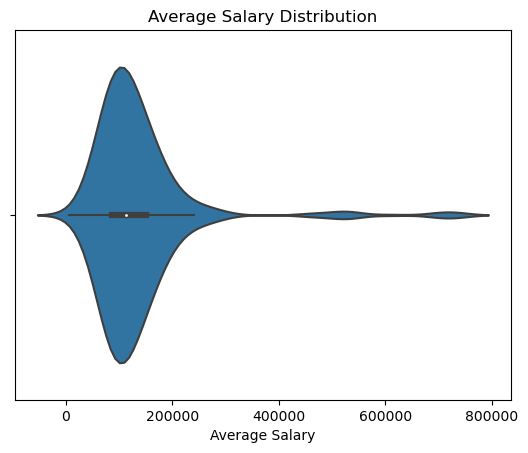

In [129]:

import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot to observe the salary data distribution
sns.violinplot(x=df_salaries['avg_salary'])
plt.title('Average Salary Distribution')
plt.xlabel('Average Salary')
plt.show()

Create a function to get the main role based on the job title and the 

In [130]:
def clean_titles(title):
    if 'data scientist' in title.lower():
        return 'Data Scientist'
    elif 'data analyst' in title.lower():
        return 'Data Analyst'
    elif 'data engineer' in title.lower():
        return 'Data Engineer'
    elif 'machine learning engineer' in title.lower():
        return 'Machine Learning Engineer'
    elif 'data architect' in title.lower():
        return 'data architect'
    elif 'Business analyst' in title.lower():
        return 'Business analyst'
    else:
        return 'Other'
    
# Apply the function to the 'title' column
df_salaries['title_clean'] = df_salaries['title'].apply(clean_titles)

C:\Users\juanc\AppData\Local\Temp\ipykernel_12484\13235387.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salaries['title_clean'] = df_salaries['title'].apply(clean_titles)


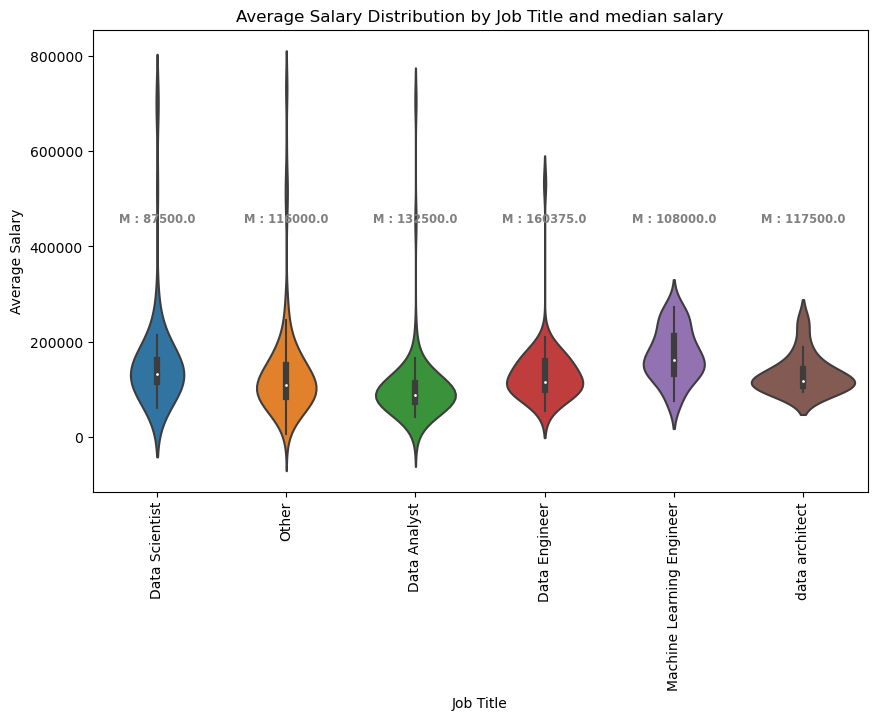

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot with 'title_clean' as hue
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='title_clean', y='avg_salary', data=df_salaries)

# Calculate the medians and add them to the plot
medians = df_salaries.groupby(['title_clean'])['avg_salary'].median().values
n = len(medians)

for xtick in ax.get_xticks():
    ax.text(x=xtick,y=450000,s=f"M : {medians[xtick]}", horizontalalignment='center',size='small',color='gray',weight='semibold')

plt.title('Average Salary Distribution by Job Title and median salary')
plt.xlabel('Job Title')
plt.ylabel('Average Salary')
plt.xticks(rotation=90)
plt.show()


# 5. **Salary Models and Predictions**

## 5.1. Cleaning and Linear Regression

## Predict the salary

Create a df1 that contain salary value.

In [218]:
df1 = df[df['avg_salary'] != 0]
df1

,title,company,description,location,jobID,jobType,platform,posting_date,City,Province,...,y,job_type_standard,years_experience,years_experience_cleaned,edu_requirements,edu_requirements_cleaned,seniority,avg_salary,salary,salary_range_nlp
3,Data Scientist - Canada,Coinbase,"at coinbase, our mission is to increase econom...","Toronto, ON",8CWTyYjpHwEtZznAAAAAAA%3D%3D,Full-time,LinkedIn,2024-03-16,Toronto,ON,...,-0.065456,full-time,5+ years,5+,[degree],[bachelor],[senior],149500.00,149500.00,[]
25,Senior Data Scientist,Trusted recruitment partner,our vancouver-based client is a well-funded st...,"Vancouver, BC",QfCKpO779bYmsV-9AAAAAA%3D%3D,Full-time,Moving2Canada,NaN,Vancouver,BC,...,-0.049470,full-time,3+ years,3+,NaN,NaN,[senior],176800.00,176800.00,[]
26,Experienced Data Scientist,BC Housing,"data scientist:\n\n$80,718.42 - $93,540.00 (an...","Burnaby, BC",jLuzohLH5frgInogAAAAAA%3D%3D,Full-time,Housing Job Match,NaN,Burnaby,BC,...,-0.035719,full-time,None,NaN,NaN,NaN,NaN,87129.21,87129.21,[]
35,Data Scientist - Canada,Coinbase,"at coinbase, our mission is to increase econom...",Canada,GEjoGqFJigWcBAA8AAAAAA%3D%3D,Full-time,Glassdoor,2024-02-23,Canada,Canada,...,-0.072234,full-time,5+ years,5+,[degree],[bachelor],[senior],150000.00,150000.00,[]
36,"Director, Data Science",Fraser Health,salary range\n\nthe salary range for this posi...,"Surrey, BC",BDQIswy_NmrYTGvOAAAAAA%3D%3D,Full-time,Fraser Health Careers - Fraser Health Authority,NaN,Surrey,BC,...,0.041175,full-time,None,NaN,[master],[master],[senior],148896.00,148896.00,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,Senior Data Analyst,ServiceNow,"company descriptionat servicenow, our technolo...","Toronto, ON",FhHrhBzDbFojwAIRAAAAAA%3D%3D,Full-time,Ai-Jobs.net,NaN,Toronto,ON,...,-0.051967,full-time,5+ years,5+,[bachelor],[bachelor],NaN,165240.00,165240.00,[]
2294,Senior Machine Learning Engineer (Chat Agent),Cresta,"we are a silicon valley series c startup, spun...","Toronto, ON",KRGjw_RFTMAc2qf_AAAAAA%3D%3D,Full-time,Karkidi,2024-03-18,Toronto,ON,...,-0.113030,full-time,5 years,5+,[phd],[phd],NaN,142500.00,142500.00,[]
2311,"Senior Staff Machine Learning Engineer, Innova...",Mozilla Corporation,the company\n\nthe mozilla corporation is the ...,"Toronto, ON",3e2o3LnEjmK7EZAGAAAAAA%3D%3D,Full-time,Karkidi,NaN,Toronto,ON,...,-0.167829,full-time,5 years,5+,NaN,NaN,[senior],142500.00,142500.00,[]
2348,Consulting Statistician,Alimentiv,as a member of alimentiv’s statistical center ...,"Toronto, ON (+6 others)",PgXdRxVlbJ3tG6zwAAAAAA%3D%3D,Full-time,Lever,NaN,Toronto,ON (+6 others),...,-0.115331,full-time,6 years,6+,NaN,NaN,NaN,127250.00,127250.00,[]


Clean the data.

In [219]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460 entries, 3 to 2453
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     460 non-null    object 
 1   company                   460 non-null    object 
 2   description               460 non-null    object 
 3   location                  460 non-null    object 
 4   jobID                     460 non-null    object 
 5   jobType                   460 non-null    object 
 6   platform                  460 non-null    object 
 7   posting_date              346 non-null    object 
 8   City                      460 non-null    object 
 9   Province                  460 non-null    object 
 10  cluster                   460 non-null    int32  
 11  x                         460 non-null    float64
 12  y                         460 non-null    float64
 13  job_type_standard         460 non-null    object 
 14  years_experien

Drop unrelated column and modify the data type of years_experience.

In [221]:
df1.drop(columns=['description','jobID','company','location','jobID','platform','posting_date','jobType','years_experience','edu_requirements','cluster', 'years_experience','x','y','salary','salary_range_nlp'], inplace=True)
df1['years_experience_cleaned'] = df1['years_experience_cleaned'].str.replace('+', '')
# Converting the column to numeric datatype
df1['years_experience_cleaned'] = pd.to_numeric(df1['years_experience_cleaned'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460 entries, 3 to 2453
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     460 non-null    object 
 1   City                      460 non-null    object 
 2   Province                  460 non-null    object 
 3   job_type_standard         460 non-null    object 
 4   years_experience_cleaned  245 non-null    float64
 5   edu_requirements_cleaned  60 non-null     object 
 6   seniority                 168 non-null    object 
 7   avg_salary                460 non-null    float64
dtypes: float64(2), object(6)
memory usage: 32.3+ KB


C:\Users\juanc\AppData\Local\Temp\ipykernel_12484\298520028.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns=['description','jobID','company','location','jobID','platform','posting_date','jobType','years_experience','edu_requirements','cluster', 'years_experience','x','y','salary','salary_range_nlp'], inplace=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_12484\298520028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['years_experience_cleaned'] = df1['years_experience_cleaned'].str.replace('+', '')
C:\Users\juanc\AppData\Local\Temp

We will first clean the title column using nlp technique following by tokenization, stopword removal, lemmatization, and punctuation removal.

In [222]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [223]:
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize WordNetLemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean and preprocess text
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove punctuation
    tokens = [token.lower() for token in tokens if token not in string.punctuation]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

# Apply preprocessing to the 'title' column
df1['clean_title'] = df1['title'].apply(preprocess_text)

print(df1)


                                                  title       City  \
3                               Data Scientist - Canada    Toronto   
25                                Senior Data Scientist  Vancouver   
26                           Experienced Data Scientist    Burnaby   
35                              Data Scientist - Canada     Canada   
36                               Director, Data Science     Surrey   
...                                                 ...        ...   
1999                                Senior Data Analyst    Toronto   
2294      Senior Machine Learning Engineer (Chat Agent)    Toronto   
2311  Senior Staff Machine Learning Engineer, Innova...    Toronto   
2348                            Consulting Statistician    Toronto   
2453          Associate Manager Intelligence Operations   Winnipeg   

            Province job_type_standard  years_experience_cleaned  \
3                 ON         full-time                       5.0   
25                BC   

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\juanc\AppData\Local\Temp\ipykernel_12484\1947476950.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['clean_title'] = df1['title'].apply(preprocess_text)


In [224]:
df1['clean_title']

3                               [data, scientist, canada]
25                              [senior, data, scientist]
26                         [experienced, data, scientist]
35                              [data, scientist, canada]
36                              [director, data, science]
                              ...                        
1999                              [senior, data, analyst]
2294    [senior, machine, learning, engineer, chat, ag...
2311    [senior, staff, machine, learning, engineer, i...
2348                           [consulting, statistician]
2453        [associate, manager, intelligence, operation]
Name: clean_title, Length: 460, dtype: object

Since'clean_title','edu_requirements_cleaned' and 'seniority' are list columns, we will use one-hot encoding to transform the columns.

In [225]:
import pandas as pd

# one-hot encoding
edu_requirements_dummy = df1['edu_requirements_cleaned'].str.join('|').str.get_dummies()
seniority_dummy = df1['seniority'].str.join('|').str.get_dummies()

# Concatenate dummy variables with in DataFrame
df1 = pd.concat([df1.drop(columns=['edu_requirements_cleaned', 'seniority','title']),edu_requirements_dummy, seniority_dummy], axis=1)

In [226]:
title_dummy = df1['clean_title'].str.join('|').str.get_dummies()
df1 = pd.concat([df1.drop(columns=['clean_title']),title_dummy], axis=1)

job_type_standard, city, province columns are categorical variable, we will get dummy variable as well.

In [227]:
# Get dummy variables for 'job_type_standard'
job_type_dummies = pd.get_dummies(df1['job_type_standard'], prefix='job_type')

# Concatenate the dummy variables with the original DataFrame
df1 = pd.concat([df1, job_type_dummies], axis=1)
df1 = df1.drop(columns=['job_type_standard'],axis=1)

In [228]:
# Get dummy variables for 'city' and 'province'
city_dummies = pd.get_dummies(df1['City'], prefix='city')
province_dummies = pd.get_dummies(df1['Province'], prefix='province')

# Concatenate the dummy variables with the original DataFrame
df1 = pd.concat([df1, city_dummies, province_dummies], axis=1)

# Drop the original 'city' and 'province' columns if needed
df1.drop(['City', 'Province'], axis=1, inplace=True)


In [229]:
df1

,years_experience_cleaned,avg_salary,bachelor,master,phd,entry-level,intermediate,junior,senior,...,...,province_British Columbia,province_Canada,province_MB,province_NB,province_NL,province_ON,province_ON (+6 others),province_Ontario,province_QC,province_SK
3,5.0,149500.00,1,0,0,0,0,0,1,0,...,False,False,False,False,False,True,False,False,False,False
25,3.0,176800.00,0,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
26,NaN,87129.21,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
35,5.0,150000.00,1,0,0,0,0,0,1,0,...,False,True,False,False,False,False,False,False,False,False
36,NaN,148896.00,0,1,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,5.0,165240.00,1,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
2294,5.0,142500.00,0,0,1,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
2311,5.0,142500.00,0,0,0,0,0,0,1,0,...,False,False,False,False,False,True,False,False,False,False
2348,6.0,127250.00,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False


Check missing values

In [230]:
#print(X_train.isnull().sum())
#print(y_train.isnull().sum())

we will drop years_experience, since there are lots of missing values for records that contain extracted salary.

In [231]:
df1=df1.drop(['years_experience_cleaned'], axis=1) 

## Linear regeression
We have applied Recursive Feature Elimination (RFE) in the linear model.

RFE is a backward feature selection technique that recursively removes the least important features based on model coefficients or feature importance until the desired number of features is reached.
This method works well with linear models like Linear Regression and can help identify the most relevant features in the dataset.

In [232]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

# Define target variable
y = df1['avg_salary']
X = df1.drop(['avg_salary'], axis=1) 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize linear regression model
model = LinearRegression()

# Initialize RFE with the linear regression model
rfe = RFE(model, n_features_to_select=20)  # Adjust the number of features to select as needed

# Fit RFE to training data
rfe.fit(X_train, y_train)

# Transform X_train and X_test to retain only selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Train the model on the selected features
model.fit(X_train_selected, y_train)

# Make predictions on the testing data using the model trained on selected features
predictions = model.predict(X_test_selected)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Calculate R-squared score
r_squared = model.score(X_test_selected, y_test)
print("R-squared:", r_squared)


Mean Squared Error: 7.410504062447735e+33
R-squared: -1.0400800901227152e+24


In [234]:
# Compute the correlation matrix
correlation_matrix = df1.corr()

# Select the features with correlation coefficient above a certain threshold (e.g., 0.5)
relevant_features = correlation_matrix[abs(correlation_matrix['avg_salary']) > 0.2]['avg_salary'].index

# Drop irrelevant features from the dataset
df_relevant_features = df1[relevant_features]

# Check the new dataset with relevant features
print(df_relevant_features.head())


    avg_salary  analyst  aws  conversational  investment  large  model  \
3    149500.00        0    0               0           0      0      0   
25   176800.00        0    0               0           0      0      0   
26    87129.21        0    0               0           0      0      0   
35   150000.00        0    0               0           0      0      0   
36   148896.00        0    0               0           0      0      0   

    city_Toronto  
3           True  
25         False  
26         False  
35         False  
36         False  


Mean Squared Error: 6780390568.142657
R-squared: 0.04835768609623359


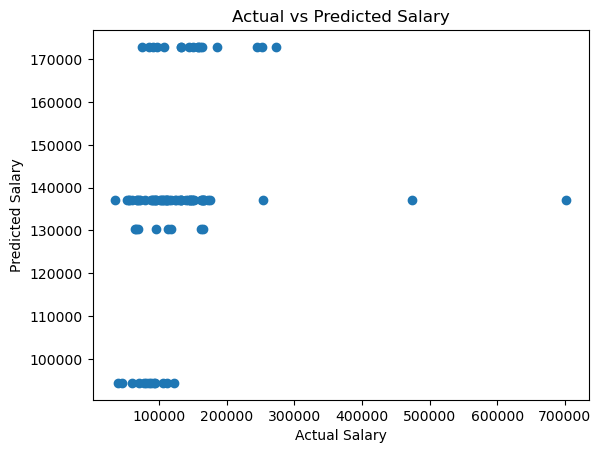

In [235]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define target variable
y = df_relevant_features['avg_salary']
X = df_relevant_features.drop(['avg_salary'], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

r_squared = model.score(X_test, y_test)
print("R-squared:", r_squared)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary")
plt.show()


## 5.2. Random Forest

Let's take a relevant subset of the total data

In [236]:
tf_data= df[df['avg_salary']>0][['avg_salary','description','title', 'City','jobType', 'company']]

## Random Forrest regression of salary, using description and title: 


In [237]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# clean description
tf_data['description'] = tf_data['description'].str.lower()  # Convert to lowercase
tf_data['description'] = tf_data['description'].str.replace('[^\w\s]', '')  # Remove punctuation
tf_data['description'] = tf_data['description'].str.replace('\n', ' ')  # Replace newline characters with space
tf_data['description'] = tf_data['description'].str.replace('\r', '')  # Remove carriage return

# Do the same for the 'title' column
tf_data['title'] = tf_data['title'].str.lower()  # Convert to lowercase
tf_data['title'] = tf_data['title'].str.replace('[^\w\s]', '')  # Remove punctuation
tf_data['title'] = tf_data['title'].str.replace('\n', ' ')  # Replace newline characters with space
tf_data['title'] = tf_data['title'].str.replace('\r', '')  # Remove carriage return

# Combine 'description' and 'title' into a single text
tf_data['text'] = tf_data['title'] + ' ' + tf_data['description']

texts = tf_data['text'].to_list()
salaries = tf_data['avg_salary'].to_list()



# Split the data into training and validation sets (80% training, 20% validation)
text_train, text_val, sal_train, sal_val = train_test_split(texts, salaries, test_size=0.2, random_state=42)

# Convert texts to feature vectors
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(text_train)
X_val = vectorizer.transform(text_val)

# Train a Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, sal_train)

# Predict salaries for the validation set
sal_pred = regressor.predict(X_val)

# Compute MAE and RMSE
mae = mean_absolute_error(sal_val, sal_pred)
rmse = np.sqrt(mean_squared_error(sal_val, sal_pred))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 53597.81271513976
Root Mean Squared Error (RMSE): 89446.31713784313


In [238]:
from sklearn.metrics import r2_score
# Compute R2 score
r2 = r2_score(sal_val, sal_pred)
print(f"R-squared (R2): {r2}")

R-squared (R2): -0.12290744299081657


In [239]:
# Print the title and the predicted salary
for title, pred_salary, sal_vals in zip(text_val, sal_pred, sal_train):
    print(f"text: {title.split()[0:3]}, Predicted Salary: {'${:,.2f}'.format(pred_salary)}, real salary: {'${:,.2f}'.format(sal_vals)} ")

text: ['strategic', 'analytics', 'consultant'], Predicted Salary: $117,932.32, real salary: $165,240.00 
text: ['scientifique', 'des', 'données'], Predicted Salary: $182,745.26, real salary: $91,200.00 
text: ['ai', '&', 'data'], Predicted Salary: $104,305.65, real salary: $158,950.00 
text: ['embedded', 'escalation', 'engineer'], Predicted Salary: $328,357.40, real salary: $62,500.00 
text: ['senior', 'software', 'engineer,'], Predicted Salary: $146,820.39, real salary: $180,000.00 
text: ['data', 'analyst', 'data'], Predicted Salary: $95,175.32, real salary: $210,800.00 
text: ['coop', 'student,', 'data'], Predicted Salary: $187,169.26, real salary: $107,172.00 
text: ['data', 'engineer', 'job'], Predicted Salary: $228,309.86, real salary: $61,058.00 
text: ['wildfire', 'data', 'scientist'], Predicted Salary: $110,949.31, real salary: $76,106.50 
text: ['machine', 'learning', 'engineer'], Predicted Salary: $142,167.41, real salary: $120,000.00 
text: ['senior', 'data', 'architect'], 

### Let's trying only the title

## Random Forrest regression of salary, using Only the title: 


In [240]:


titles = tf_data['title'].to_list()
salaries = tf_data['avg_salary'].to_list()



# Split the data into training and validation sets (80% training, 20% validation)
text_train, text_val, sal_train, sal_val = train_test_split(titles, salaries, test_size=0.2, random_state=42)

# Convert texts to feature vectors
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(text_train)
X_val = vectorizer.transform(text_val)

# Train a Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, sal_train)

# Predict salaries for the validation set
sal_pred = regressor.predict(X_val)

# Compute MAE and RMSE
mae = mean_absolute_error(sal_val, sal_pred)
rmse = np.sqrt(mean_squared_error(sal_val, sal_pred))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 45621.91726845194
Root Mean Squared Error (RMSE): 88166.50233743103


In [241]:
# Compute R2 score
r2 = r2_score(sal_val, sal_pred)
print(f"R-squared (R2): {r2}")

R-squared (R2): -0.09100378581358504


## Random Forrest using description, title, jobType and company 

In [242]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Clean the description
tf_data['description'] = tf_data['description'].str.lower().replace('[^\w\s]', '', regex=True).replace('\n', ' ').replace('\r', '')
tf_data['title'] = tf_data['title'].str.lower().replace('[^\w\s]', '', regex=True).replace('\n', ' ').replace('\r', '')

# Combine 'description', 'title', 'City', 'jobType', and 'company' into a single text
tf_data['text'] = tf_data['title'] + ' ' + tf_data['description'] + ' ' + tf_data['City'] + ' ' + tf_data['jobType'] + ' ' + tf_data['company']

texts = tf_data['text'].to_list()
salaries = tf_data['avg_salary'].to_list()

# Split the data into training and validation sets (80% training, 20% validation)
text_train, text_val, sal_train, sal_val = train_test_split(texts, salaries, test_size=0.2, random_state=42)

# Convert texts to feature vectors
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(text_train)
X_val = vectorizer.transform(text_val)

# Train a Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, sal_train)

# Predict salaries for the validation set
sal_pred = regressor.predict(X_val)

# Compute MAE and RMSE
mae = mean_absolute_error(sal_val, sal_pred)
rmse = np.sqrt(mean_squared_error(sal_val, sal_pred))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
r2 = r2_score(sal_val, sal_pred)
print(f"R-squared (R2): {r2}")


Mean Absolute Error: 53938.95
Root Mean Squared Error: 92004.58
R-squared (R2): -0.18805883558592407


# 5.3. Fine-Tuning a Deep Learning Transformer Model

### Predicting Salaries using Transformers Models and Deep learning

In [243]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification

# Load pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).to('cuda')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Cleanning the description
tf_data['description'] = tf_data['description'].str.lower()  # Convert to lowercase
tf_data['description'] = tf_data['description'].str.replace('[^\w\s]', '')  # Remove punctuation
tf_data['description'] = tf_data['description'].str.replace('\n', ' ')  # Replace newline characters with space
tf_data['description'] = tf_data['description'].str.replace('\r', '')  # Remove carriage return

job_descriptions = tf_data['description'].to_list()
salaries = tf_data['avg_salary'].to_list()

# Scale salaries to the range [0, 1]
min_salary = min(salaries)
max_salary = max(salaries)
scaled_salaries = [(x - min_salary) / (max_salary - min_salary) for x in salaries]

# Split the data into training and validation sets (80% training, 20% validation)
desc_train, desc_val, sal_train, sal_val = train_test_split(job_descriptions, scaled_salaries, test_size=0.2, random_state=42)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Process job descriptions in batches
batch_size = 16  # Reduced batch size
gradient_accumulation_steps = 2  # Number of batches to accumulate gradients before updating weights

num_epochs = 1  # Define the number of epochs

for epoch in range(num_epochs):
    for i in range(0, len(desc_train), batch_size):
        model.zero_grad()  # Reset gradients at the beginning of each accumulation step

        for j in range(i, min(i + batch_size * gradient_accumulation_steps, len(desc_train)), batch_size):
            batch_descriptions = desc_train[j:j+batch_size]
            batch_salaries = sal_train[j:j+batch_size]

            # Tokenize job descriptions
            inputs = tokenizer(batch_descriptions, padding=True, truncation=True, return_tensors="pt").to('cuda')

            # Convert salaries to tensor
            labels = torch.tensor(batch_salaries).to('cuda')

            # Fine-tune model
            outputs = model(**inputs, labels=labels)
            #This model uses the Mean Squared Error (MSE) loss function when num_labels=1
            loss = outputs.loss
            loss.backward()

        optimizer.step()  # Update weights after gradient accumulation steps

        print(f"Processed batch {i // batch_size + 1}")

# Predict salaries

# Predict salaries in batches to avoid memory errors/ limitations
predicted_salaries_scaled = []
with torch.no_grad():
    for i in range(0, len(desc_train), batch_size):
        batch_descriptions = desc_train[i:i+batch_size]
        # BERT only accepts up to 512 tokens
        inputs = tokenizer(batch_descriptions, padding=True, truncation=True, return_tensors="pt").to('cuda')
        outputs = model(**inputs)
        batch_predictions = outputs.logits.squeeze().detach().cpu().numpy()

        # Check if batch_predictions is a 0-d array (scalar) when the batch is 1
        if batch_predictions.ndim == 0:
            batch_predictions = np.array([batch_predictions.item()])  # Convert to 1-d array

        predicted_salaries_scaled.extend(batch_predictions)
        
# Save the custom Fine tunned Model 
model.save_pretrained('Salary_pred_model_from_bert')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5
Processed batch 6
Processed batch 7
Processed batch 8
Processed batch 9
Processed batch 10
Processed batch 11
Processed batch 12
Processed batch 13
Processed batch 14
Processed batch 15
Processed batch 16
Processed batch 17
Processed batch 18
Processed batch 19
Processed batch 20
Processed batch 21
Processed batch 22
Processed batch 23


### Convert back to the original scale

In [244]:
s = np.array(predicted_salaries_scaled ).astype(float) 
predicted_salaries= s*(max_salary - min_salary) + min_salary

In [245]:
for e in predicted_salaries:
    print(e)

134121.81386089325
103394.63487307729
135051.63208307326
97810.15457987042
96272.15149137007
128097.95530895145
105655.91256556661
91860.51033885778
64737.23215323687
136850.55266375098
34027.314454156905
150249.40678131583
128502.2354329303
79604.00711528958
134600.88385308534
115541.31525110455
94761.50366321953
89008.65657506885
92091.48256290705
106277.69904506208
111116.01818756016
118786.56784833224
108656.55331707002
100717.72880449893
124362.71885027738
120487.00297600777
88715.46986648442
107781.22842416169
135783.41516125202
93938.4947555177
115648.75985050948
131461.83786412328
105036.42831520738
146440.01030956957
121239.61471212657
109116.10865946116
83152.05171200262
114406.40316351505
110036.31616095455
93509.33535346763
107824.09115246685
88085.20749151336
139542.22774942967
95270.26372361185
113390.55541672559
86907.67701597513
84354.66236768292
74684.57783402504
68806.72078973427
62083.77189930529
97934.39893622698
135910.65675931424
82611.55455420168
44132.2895286698

## Performance of the trained model on the training data

In [246]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate actual_salaries for the training
actual_salaries = np.array(sal_train) * (max_salary - min_salary) + min_salary

# Calculate MSE
mse = mean_squared_error(actual_salaries, predicted_salaries)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate R² score
r2 = r2_score(actual_salaries, predicted_salaries)
print(f"R-squared (R²) score: {r2}")

Mean Squared Error (MSE): 10330800755.869356
R-squared (R²) score: 0.04824121023467842
